In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [2]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Rare Functional Variant Detailed analysis</h2>

In [4]:
variant_df_filtered = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter on human variants
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "

human_variant_df = variant_df.query(filter_query).copy()
human_variant_df_filtered = variant_df_filtered.query(filter_query).copy()

human_variant_df['delta_logodds_pred'] = human_variant_df['mean_delta_logodds_pred']
human_variant_df_filtered['delta_logodds_pred'] = human_variant_df_filtered['mean_delta_logodds_pred']


var_df = human_variant_df_filtered.query("variant == 'snv' and snv_pos != -1").copy()

mer6_weights_doubledope = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_doubledope_weights.npy')[1:]
mer6_weights_simple = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_simple_weights.npy')[1:]
mer6_weights_tomm5 = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_tomm5_weights.npy')[1:]

mer6_weights_use = (mer6_weights_tomm5[:4096] + mer6_weights_simple[:4096]) / 2.
mer6_weights_pas = mer6_weights_doubledope[4096:2*4096]
mer6_weights_dse = (mer6_weights_tomm5[2*4096:] + mer6_weights_simple[2*4096:]) / 2.

var_df = append_6mer_delta_logodds_scores(var_df, mer6_weights_use, mer6_weights_pas, mer6_weights_dse)
var_df['delta_logodds_pred'] = var_df['mean_delta_logodds_pred']


<h2>Gain/Loss of canonical CSE Hexamer (AATAAA/ATTAAA)</h2>

Gain of Motif (Neural Net model)


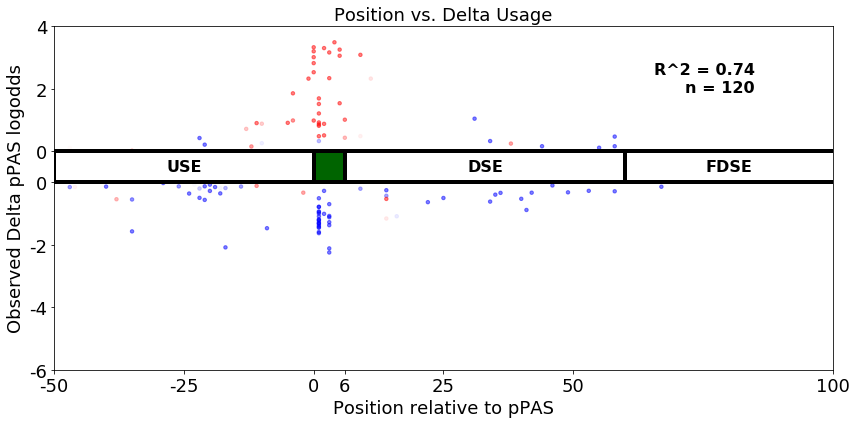

Gain of Motif (Hexamer model)


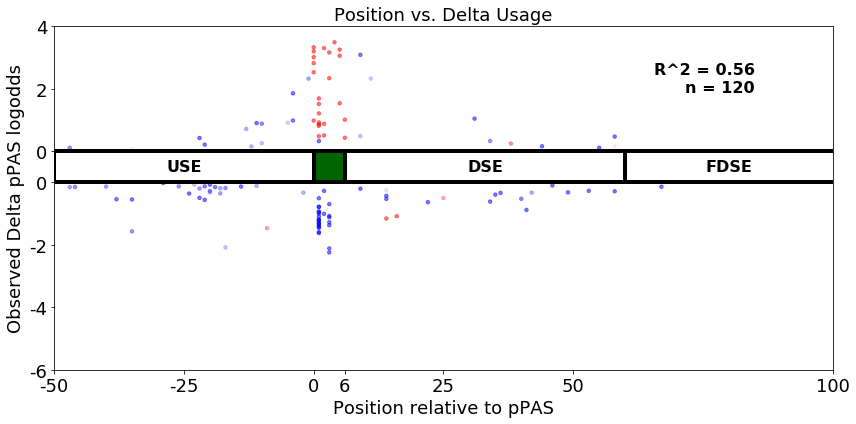


# Gain of ['AATAAA', 'ATTAAA'] = 120
# Neural net / Observation agreement = 103
# Neural net / 6-mer model agreement = 100
## Gain of motif in USE = 39
### Gain of motif, Loss of function = 26
### Gain of motif, Gain of function = 13
### Neural net / 6-mer model agreement = 26
## Gain of motif in DSE = 31
### Gain of motif, Loss of function = 19
### Gain of motif, Gain of function = 12
### Neural net / 6-mer model agreement = 24
Loss of Motif (Neural Net model)


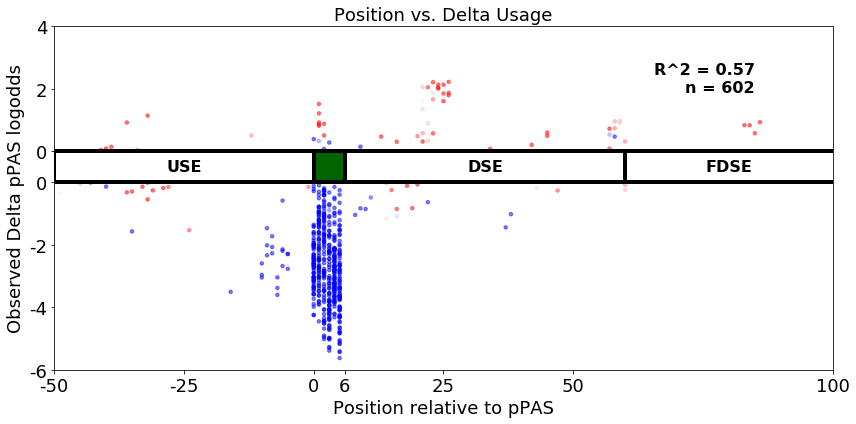

Loss of Motif (Hexamer model)


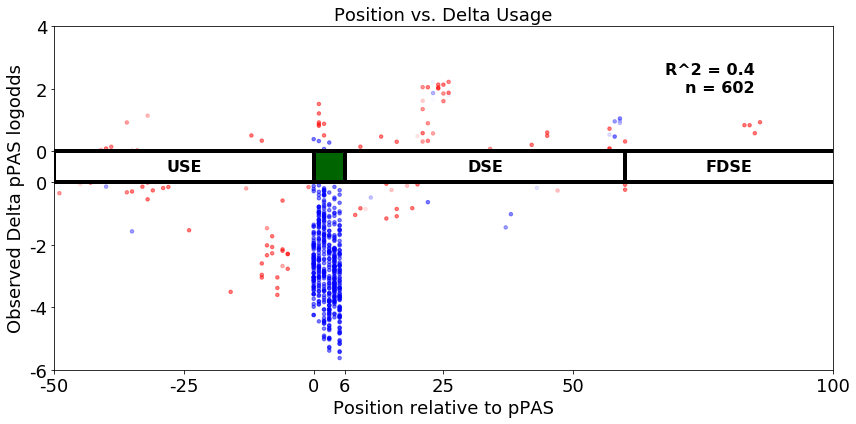


# Loss of ['AATAAA', 'ATTAAA'] = 602
# Neural net / Observation agreement = 567
# Neural net / 6-mer model agreement = 566
## Loss of motif in USE = 45
### Loss of motif, Loss of function = 36
### Loss of motif, Gain of function = 9
### Neural net / 6-mer model agreement = 23
## Loss of motif in DSE = 63
### Loss of motif, Loss of function = 19
### Loss of motif, Gain of function = 44
### Neural net / 6-mer model agreement = 49


In [6]:
#Gain/Loss of de novo canonical PAS (CSE Hexamer)
motifs = ['AATAAA', 'ATTAAA']
_, _ = plot_gain_loss_of_motifs(var_df, motifs, name_prefix='canonical_pas', plot_logos=False, save_figs=False)


Gain of canonical competing CSE:
Gene = PTEN.15
WT seq = ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA
SNV pos = 88
SNV nt = T
ClinVar id = Missing


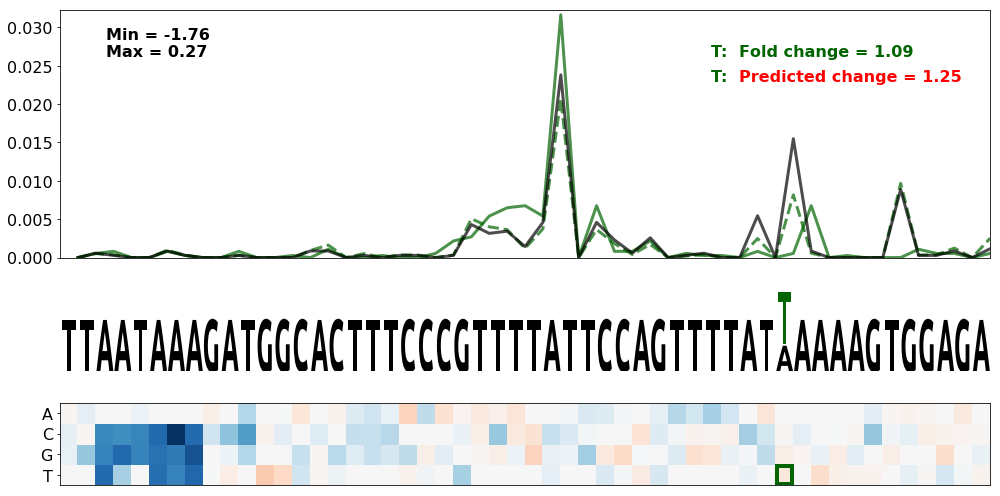

Gene = SMAD4.1
WT seq = AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT
SNV pos = 75
SNV nt = T
ClinVar id = Missing


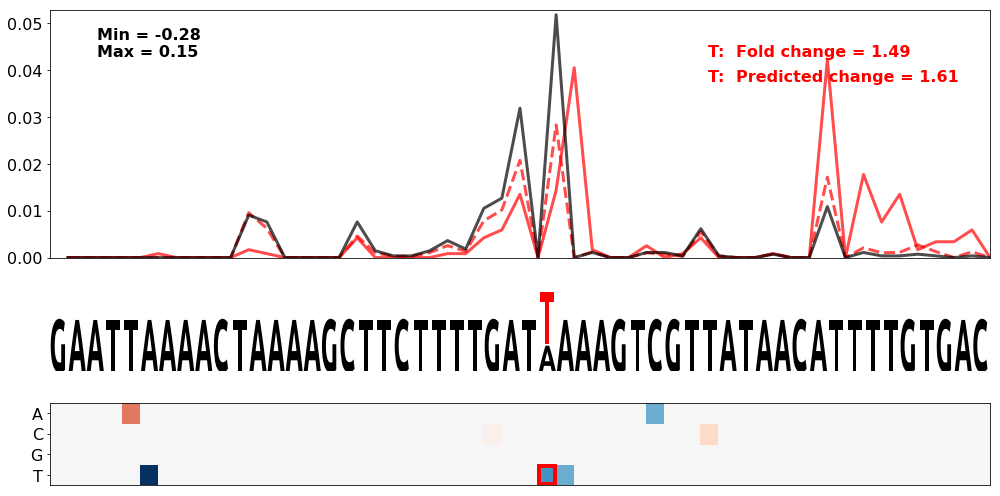

Loss of canonical competing CSE:
Gene = COL3A1.1
WT seq = TGTAAGCTTGTATGTGGTTGTTGATCTTTTTTTTCCTTACAGACACCCATAATAAAATATCATATTAAAATTCTCCTGTTTTTTGTCACTTTTCAAAGATTTAAAAAATGCACGTCTACATTAAGGAACTCCAGTAATCTTGAAAAAGTATATTGAATTCTAAC
SNV pos = 68
SNV nt = C
ClinVar id = Missing


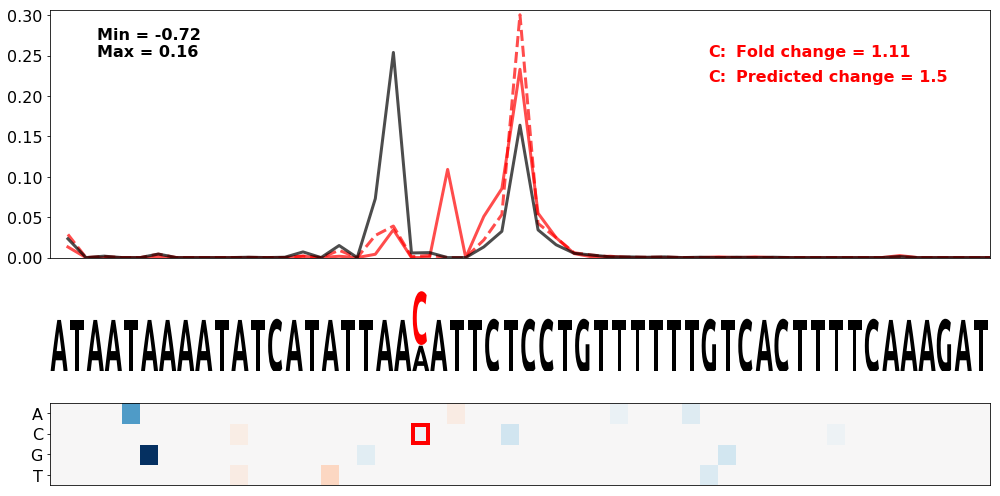

Gene = PTEN.12
WT seq = TTTGTTAACAACCCTTTATCTCTTAGTGTTATAAACTCCACTTAAAACTGATTAAAGTCTCATTCTTGTCATTGTGTGGGTGTTTTATTAAATGAGAGTTTATAATTCAAATTGCTTAAGTCCATTGAAGTTTTAATTAATGGGCAGCCAAATGTGAATACAAA
SNV pos = 87
SNV nt = G
ClinVar id = Missing


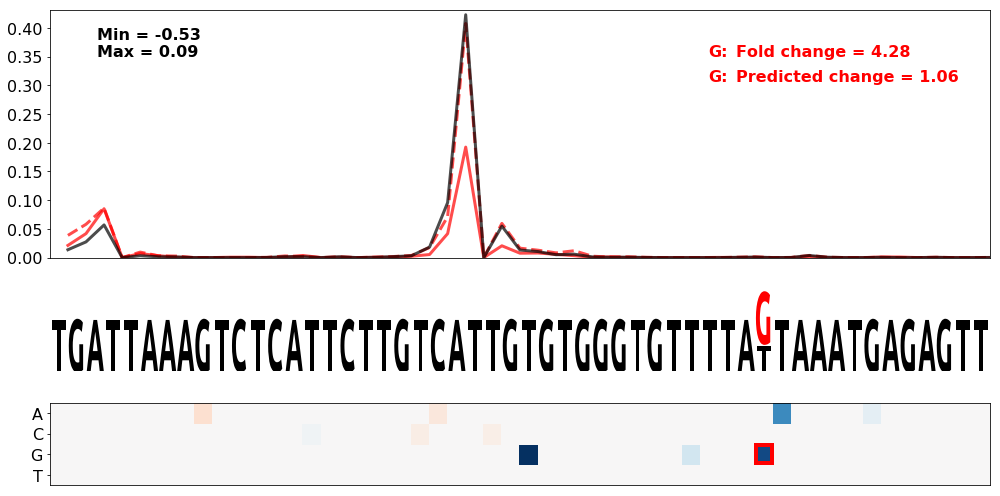

Gene = COL3A1.1
WT seq = TGTAAGCTTGTATGTGGTTGTTGATCTTTTTTTTCCTTACAGACACCCATAATAAAATATCATATTAAAATTCTCCTGTTTTTTGTCACTTTTCAAAGATTTAAAAAATGCACGTCTACATTAAGGAACTCCAGTAATCTTGAAAAAGTATATTGAATTCTAAC
SNV pos = 63
SNV nt = T
ClinVar id = Missing


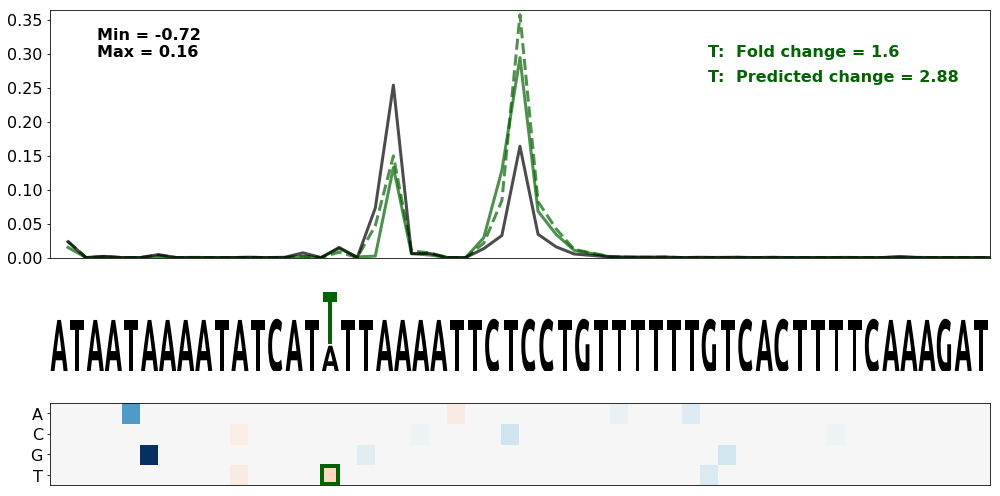

Gene = TMEM43.3
WT seq = AAAATTTGAAAGCTTTGGAAAACCAAATTTGTAATATCATTGTATTTTTTATTAAAAGTTTTGTAATAAATTTCTAAATTATCTTCTGGTGTGGGACTTTAACAAACATCCTATTTTTAGTTTCAGATTTTTTTTTTTTGGCATTCTTTCCAAAATGTCTGTAA
SNV pos = 66
SNV nt = G
ClinVar id = Missing


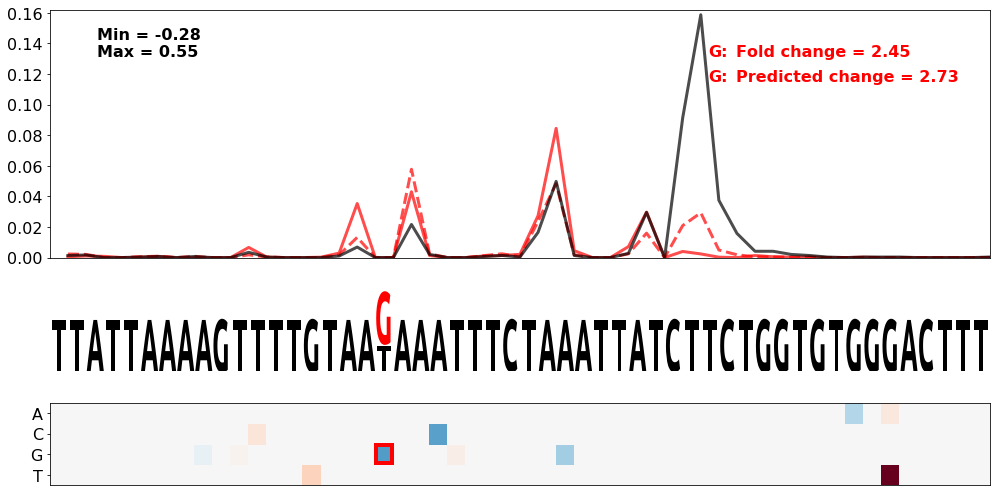

Gene = TMEM43.3
WT seq = AAAATTTGAAAGCTTTGGAAAACCAAATTTGTAATATCATTGTATTTTTTATTAAAAGTTTTGTAATAAATTTCTAAATTATCTTCTGGTGTGGGACTTTAACAAACATCCTATTTTTAGTTTCAGATTTTTTTTTTTTGGCATTCTTTCCAAAATGTCTGTAA
SNV pos = 69
SNV nt = C
ClinVar id = Missing


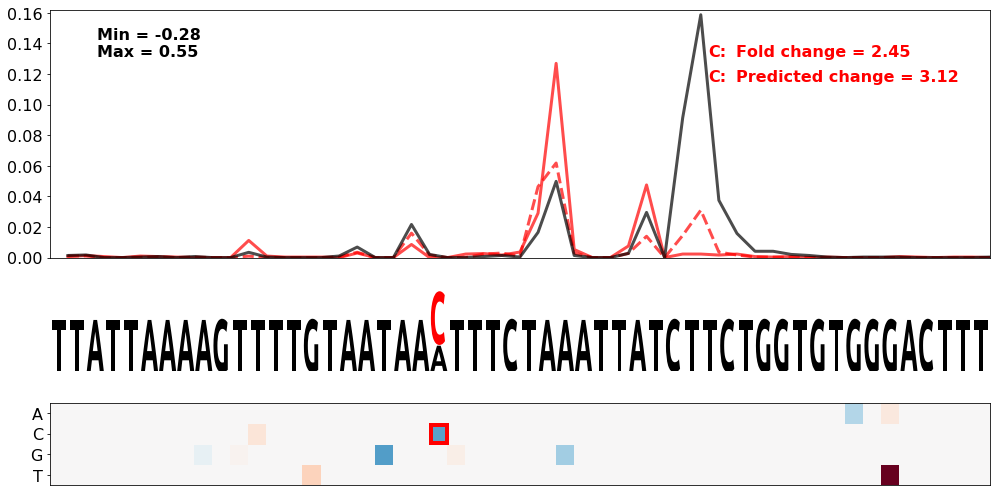

In [7]:
print('Gain of canonical competing CSE:')

experiment_name = 'gain_of_cse'

gene_names = [
    'PTEN.15',
    'SMAD4.1'
]

snv_list = [
    [(88, 'T', 'darkgreen')],
    [(75, 'T', 'red')]
]

wt_seq_list = [
    'ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA',
    'AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, fold_change_from_cut_range=[60, 90], seq_start=48, seq_end=100, save_figs=False)

print('Loss of canonical competing CSE:')

experiment_name = 'loss_of_cse'

gene_names = [
    'COL3A1.1',
    'PTEN.12',
    'COL3A1.1',
    'TMEM43.3',
    'TMEM43.3'
]

snv_list = [
    [(68, 'C', 'red')],
    [(87, 'G', 'red')],
    [(63, 'T', 'darkgreen')],
    [(66, 'G', 'red')],
    [(69, 'C', 'red')]
]

wt_seq_list = [
    'TGTAAGCTTGTATGTGGTTGTTGATCTTTTTTTTCCTTACAGACACCCATAATAAAATATCATATTAAAATTCTCCTGTTTTTTGTCACTTTTCAAAGATTTAAAAAATGCACGTCTACATTAAGGAACTCCAGTAATCTTGAAAAAGTATATTGAATTCTAAC',
    'TTTGTTAACAACCCTTTATCTCTTAGTGTTATAAACTCCACTTAAAACTGATTAAAGTCTCATTCTTGTCATTGTGTGGGTGTTTTATTAAATGAGAGTTTATAATTCAAATTGCTTAAGTCCATTGAAGTTTTAATTAATGGGCAGCCAAATGTGAATACAAA',
    'TGTAAGCTTGTATGTGGTTGTTGATCTTTTTTTTCCTTACAGACACCCATAATAAAATATCATATTAAAATTCTCCTGTTTTTTGTCACTTTTCAAAGATTTAAAAAATGCACGTCTACATTAAGGAACTCCAGTAATCTTGAAAAAGTATATTGAATTCTAAC',
    'AAAATTTGAAAGCTTTGGAAAACCAAATTTGTAATATCATTGTATTTTTTATTAAAAGTTTTGTAATAAATTTCTAAATTATCTTCTGGTGTGGGACTTTAACAAACATCCTATTTTTAGTTTCAGATTTTTTTTTTTTGGCATTCTTTCCAAAATGTCTGTAA',
    'AAAATTTGAAAGCTTTGGAAAACCAAATTTGTAATATCATTGTATTTTTTATTAAAAGTTTTGTAATAAATTTCTAAATTATCTTCTGGTGTGGGACTTTAACAAACATCCTATTTTTAGTTTCAGATTTTTTTTTTTTGGCATTCTTTCCAAAATGTCTGTAA'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, fold_change_from_cut_range=[60, 90], seq_start=48, seq_end=100, save_figs=False)


<h2>Gain/Loss of cryptic CSE Hexamer (NATAAA/ANTAAA)</h2>

Gain of Motif (Neural Net model)


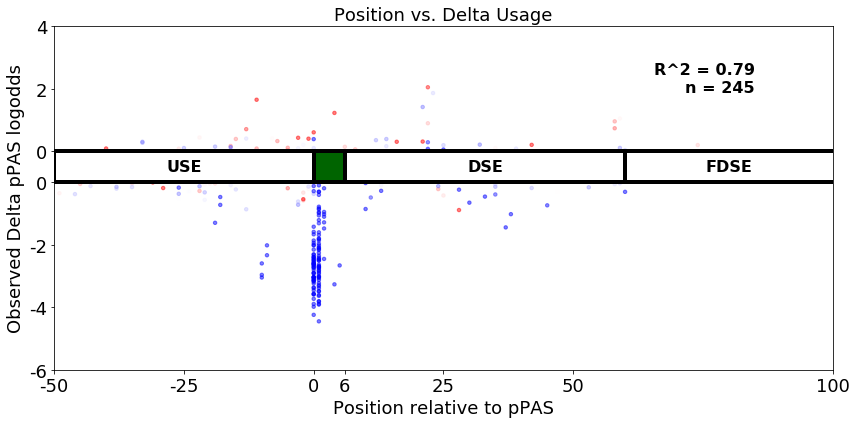

Gain of Motif (Hexamer model)


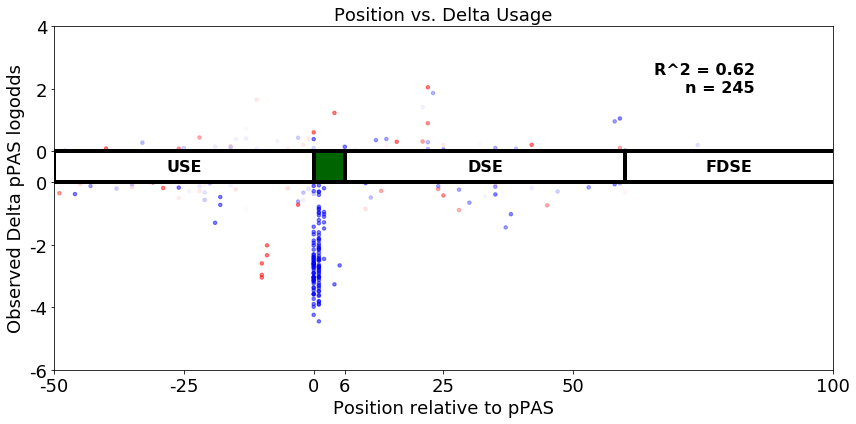


# Gain of ['TATAAA', 'GATAAA', 'CATAAA', 'ACTAAA', 'AGTAAA'] = 245
# Neural net / Observation agreement = 200
# Neural net / 6-mer model agreement = 209
## Gain of motif in USE = 67
### Gain of motif, Loss of function = 42
### Gain of motif, Gain of function = 25
### Neural net / 6-mer model agreement = 45
## Gain of motif in DSE = 50
### Gain of motif, Loss of function = 24
### Gain of motif, Gain of function = 26
### Neural net / 6-mer model agreement = 37
Loss of Motif (Neural Net model)


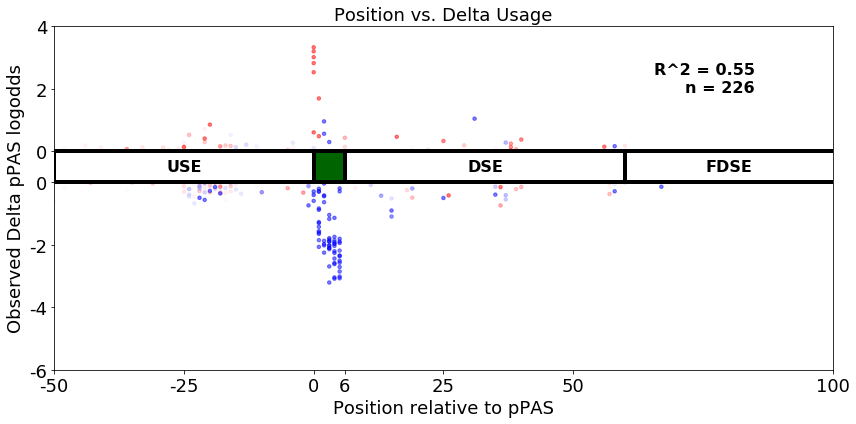

Loss of Motif (Hexamer model)


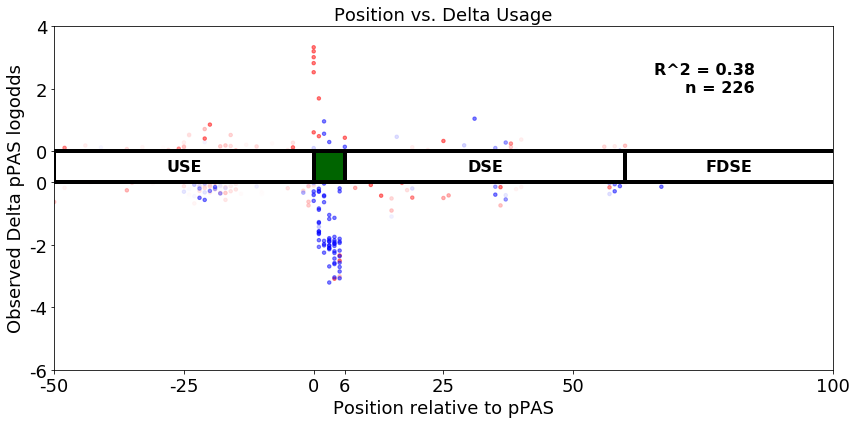


# Loss of ['TATAAA', 'GATAAA', 'CATAAA', 'ACTAAA', 'AGTAAA'] = 226
# Neural net / Observation agreement = 167
# Neural net / 6-mer model agreement = 174
## Loss of motif in USE = 96
### Loss of motif, Loss of function = 67
### Loss of motif, Gain of function = 29
### Neural net / 6-mer model agreement = 65
## Loss of motif in DSE = 49
### Loss of motif, Loss of function = 29
### Loss of motif, Gain of function = 20
### Neural net / 6-mer model agreement = 33


In [8]:
#Gain/Loss of de novo cryptic PAS (CSE Hexamer)
motifs = ['TATAAA', 'GATAAA', 'CATAAA', 'ACTAAA', 'AGTAAA']
_, _ = plot_gain_loss_of_motifs(var_df, motifs, name_prefix='cryptic_pas', plot_logos=False, save_figs=False)


Gain of cryptic competing CSE:
Gene = PTEN.24
WT seq = GAGTTAAGTAATTTCACTGAAATTGATTGCTTTTTGTGTCTTGGAGTCAAAATAAATAACTGAAATCTACTATACTTGGCTCATGCTTAATTAATATACTTAGACCATATTTCGGATGAATTATTCACAGAATCTAAAGGAGTATCCTCGTGTTCTTACCTTCT
SNV pos = 72
SNV nt = A
ClinVar id = Missing


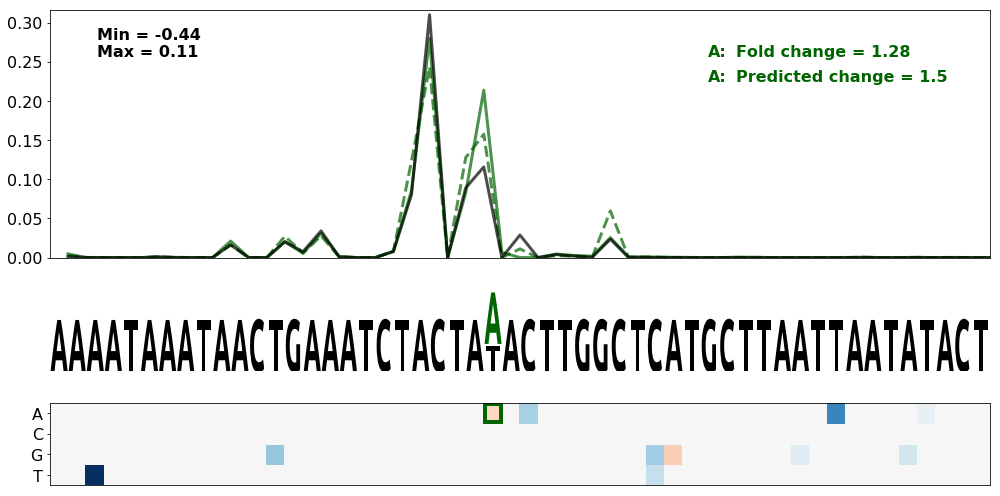

Gene = DOCK8.2
WT seq = ATTTGAGAATTAAATTATATATTTTTAATATGACTGTGACCTTGACTGATAATAAAGATGTAATAAGAATTGCAAGCTAAATGTTTCCCTTTGCAACTCATGCTTTGTGTTTTGTTTTGATGACCTACTCGCTCGTAATGTTTTGTAAGGCACTTCAGAGAGAA
SNV pos = 75
SNV nt = A
ClinVar id = NM_203447.3(DOCK8):c.*1031G>A


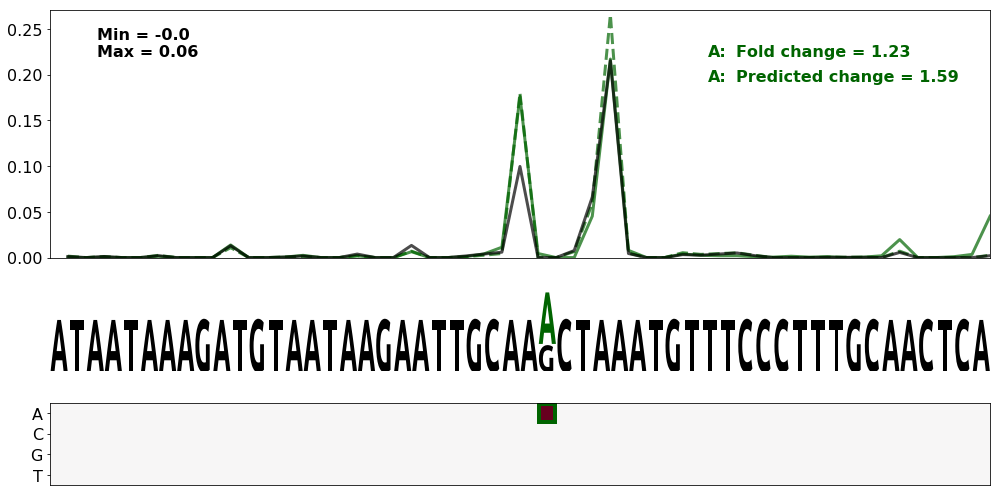

Gene = SMAD4.1
WT seq = AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT
SNV pos = 72
SNV nt = C
ClinVar id = Missing


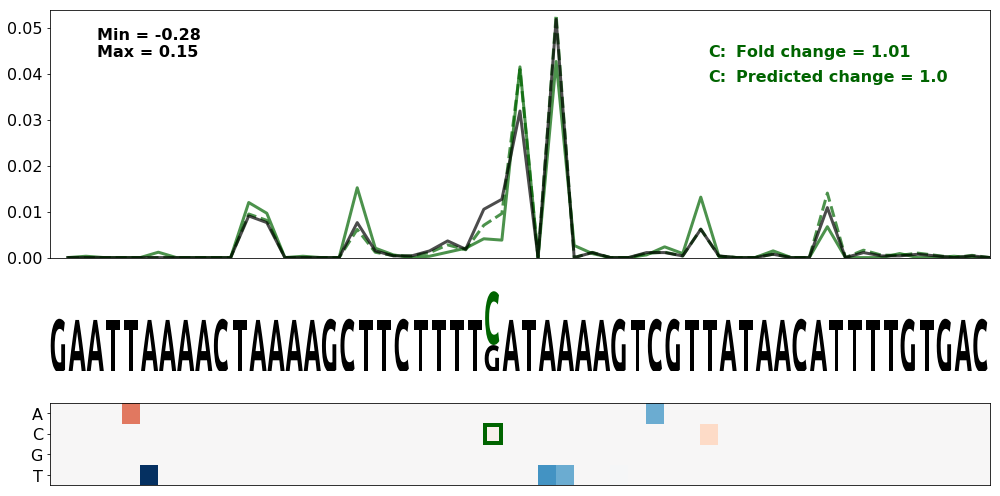

Gene = ATP7B.1
WT seq = TTTTTGTCAGATAATCATTTCTACTTCAAAAACATTTCATGCAATATTAGAATAAAGTTCCTGTCATTCCTCTAAAAATCTGCCTGTGAGTGAGATGCGTGGTCAGAGGCCAGTGCCGTCTTGTCTTCACGAGGGCTTCTGTGAGGCACTGGCTTGGCTTCATG
SNV pos = 74
SNV nt = T
ClinVar id = Missing


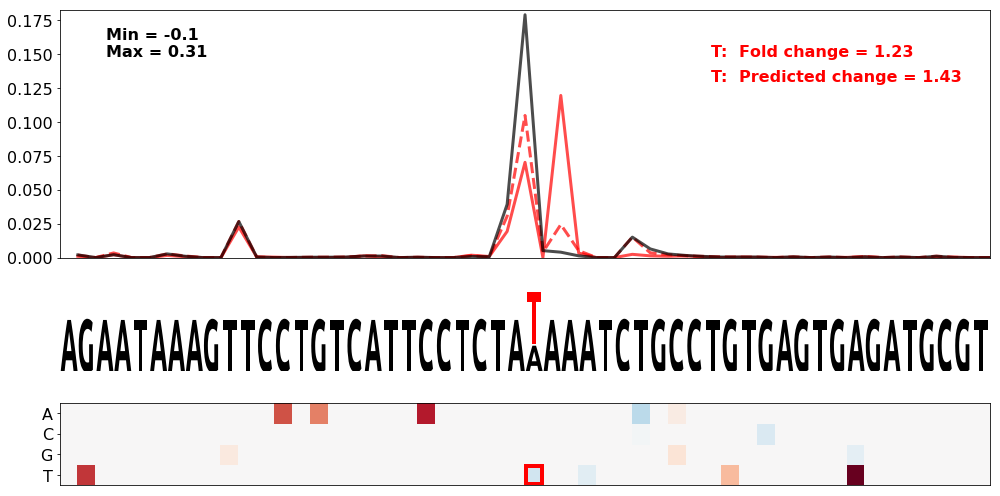

Gene = BRCA2.1
WT seq = TGTATAATATCATGTTTTCAAATCTAATTATAAATACGTTTAAAGCCAAGAATAAATCTTTTAAAAAATTGACTTGTTTCCTTCCATAACTCTGAGCCATGATTTTTCTGTTCTGTAAAAAGCATTAACAAAATTGTCTATTTTGCTACTCCCTGTAACTTAAG
SNV pos = 63
SNV nt = T
ClinVar id = Missing


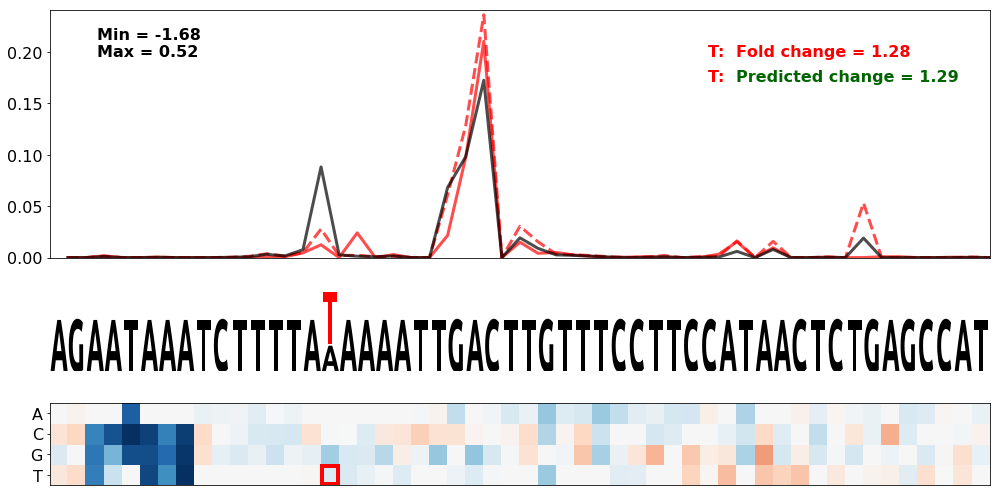

Gene = TPMT.1
WT seq = CCTAAAATCTCAAGATGGAAGATATACCACATGTAAATTATTTTAGAGCAATTAAATTGTTTTCAGGATTTTCCAAAAATGCTTCTTGTTTCATTTTATTATTTAAGTAACAGATTATCTGAGCCTCTGTGCCCTGCACACAGTGGTTTATAAATGCCTTGCCC
SNV pos = 75
SNV nt = T
ClinVar id = Missing


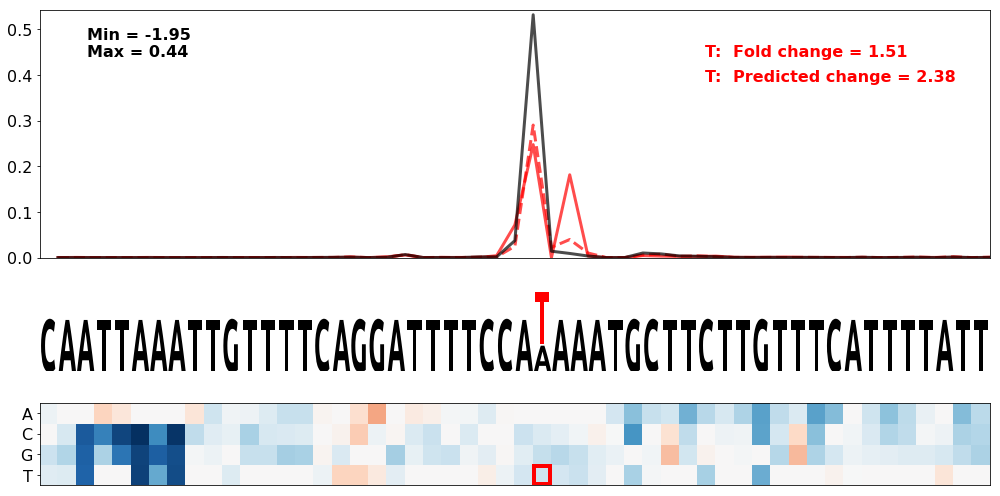

Gene = BRCA1.1
WT seq = ACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCTTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGG
SNV pos = 80
SNV nt = A
ClinVar id = Missing


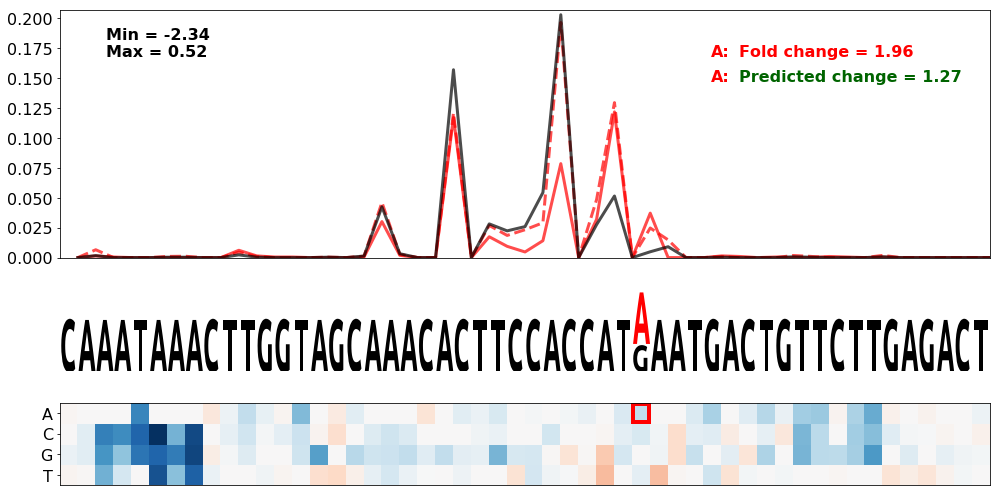

Loss of cryptic competing CSE:
Gene = SMAD4.1
WT seq = AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT
SNV pos = 75
SNV nt = T
ClinVar id = Missing


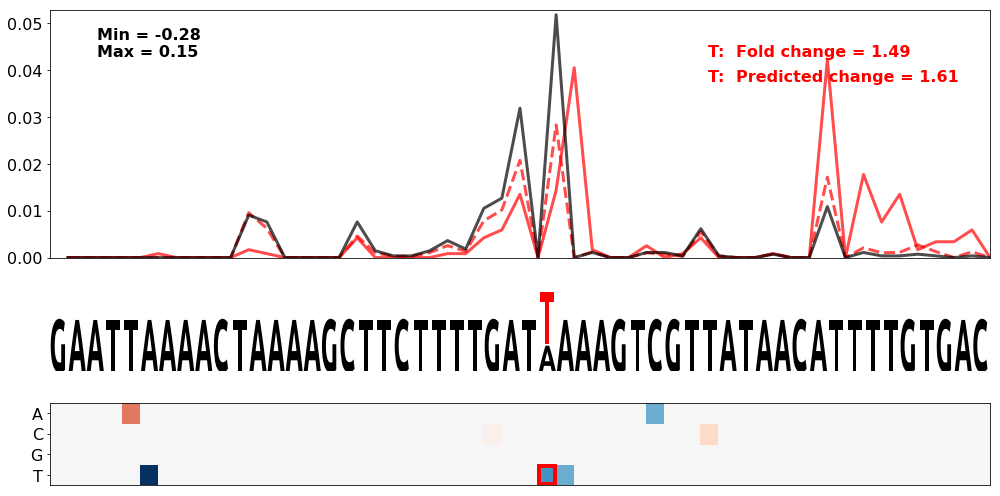

Gene = SMAD4.1
WT seq = AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT
SNV pos = 76
SNV nt = T
ClinVar id = Missing


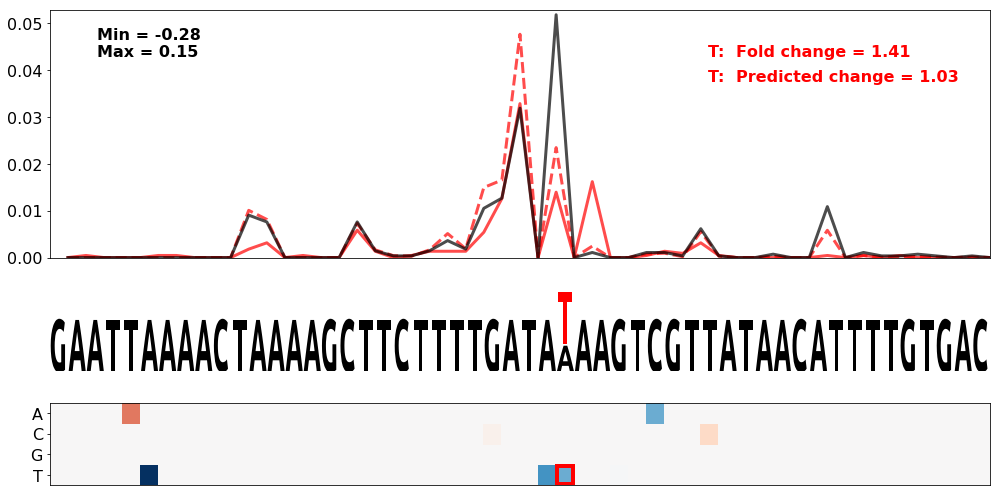

Gene = PTEN.15
WT seq = ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA
SNV pos = 89
SNV nt = C
ClinVar id = Missing


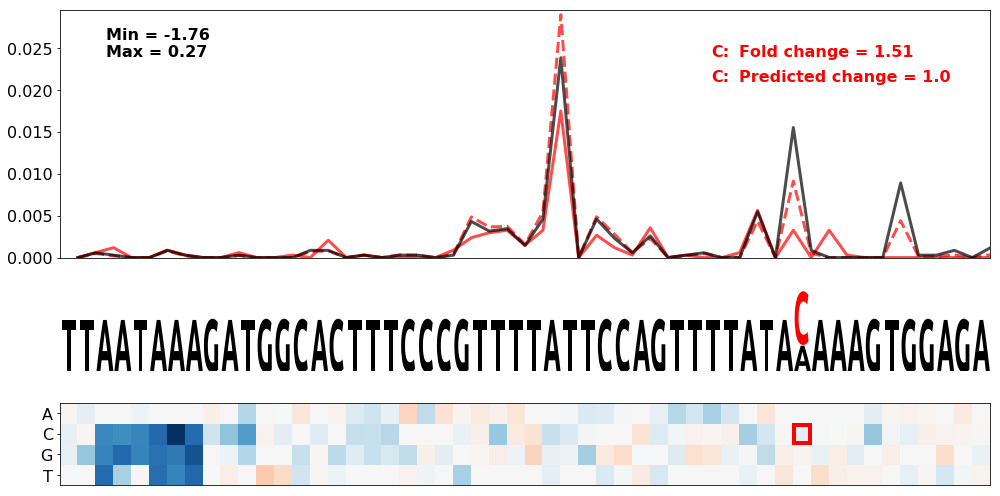

Gene = TMEM43.11
WT seq = AGTGAATTTGAGAATTAAATAATACTTGTAAAACACTTAGGACAGTATCAAATAAATGGTGAGTGATAAATGTGACCTGTTTTTGTTGTTACGGACTCTGAGAGAGGGCCCGATTCAGATCAGAGGGTCAGGGAAAGCCCTCTGAAGAAATGGGGTTCAAGCAA
SNV pos = 68
SNV nt = C
ClinVar id = Missing


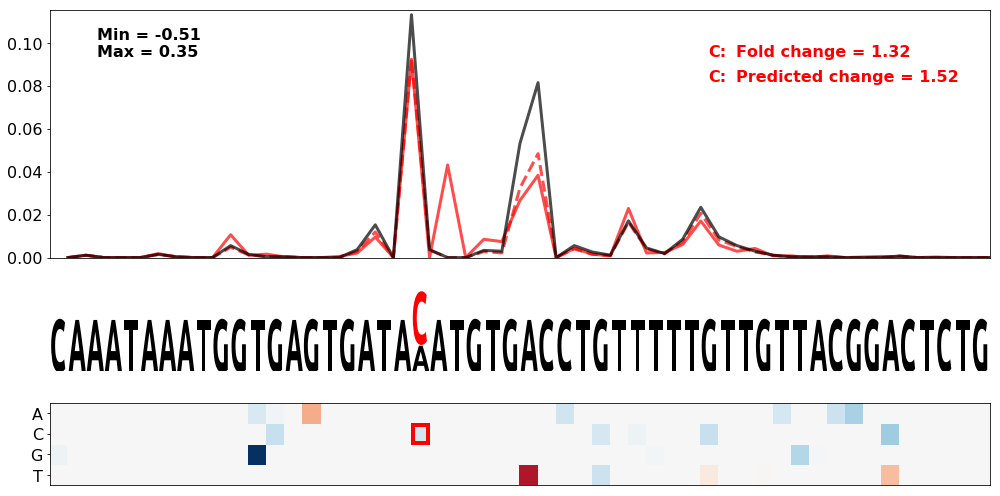

Gene = PTEN.15
WT seq = ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA
SNV pos = 88
SNV nt = G
ClinVar id = Missing


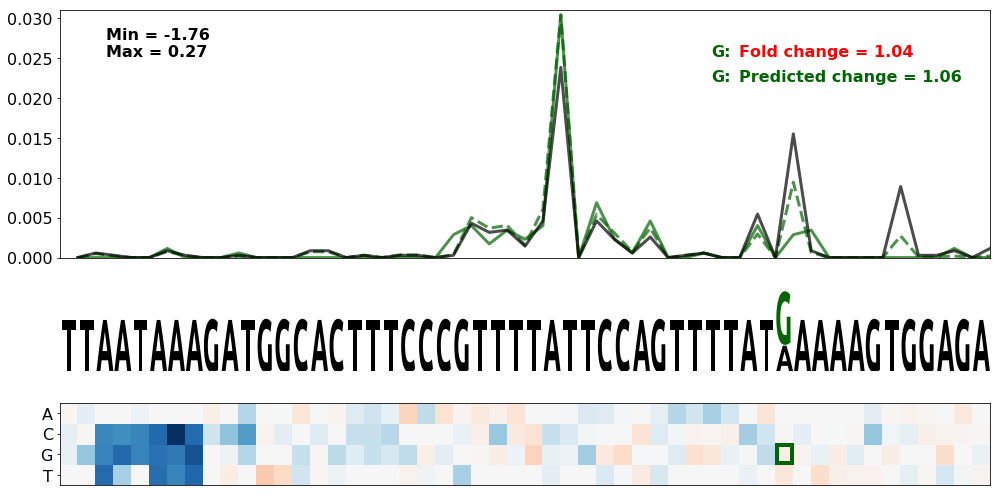

Gene = PTEN.15
WT seq = ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA
SNV pos = 88
SNV nt = T
ClinVar id = Missing


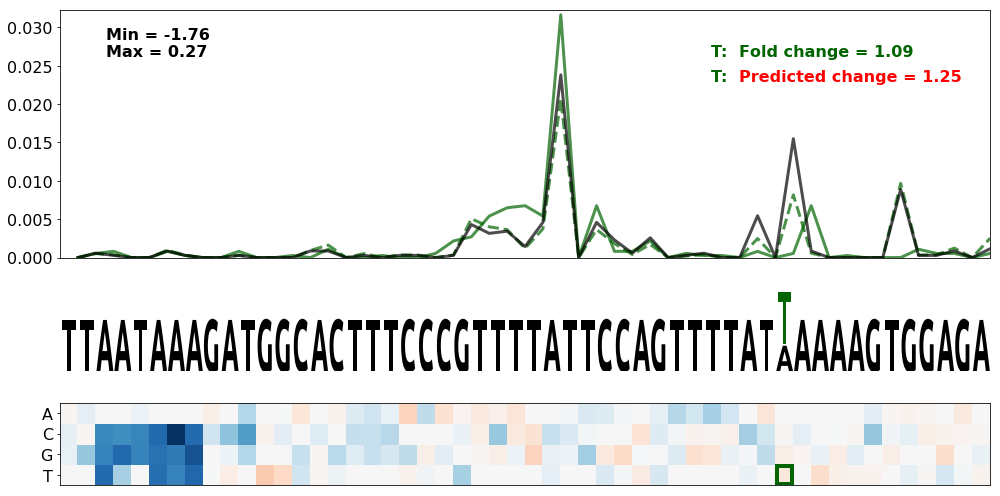

Gene = PTEN.15
WT seq = ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA
SNV pos = 87
SNV nt = A
ClinVar id = Missing


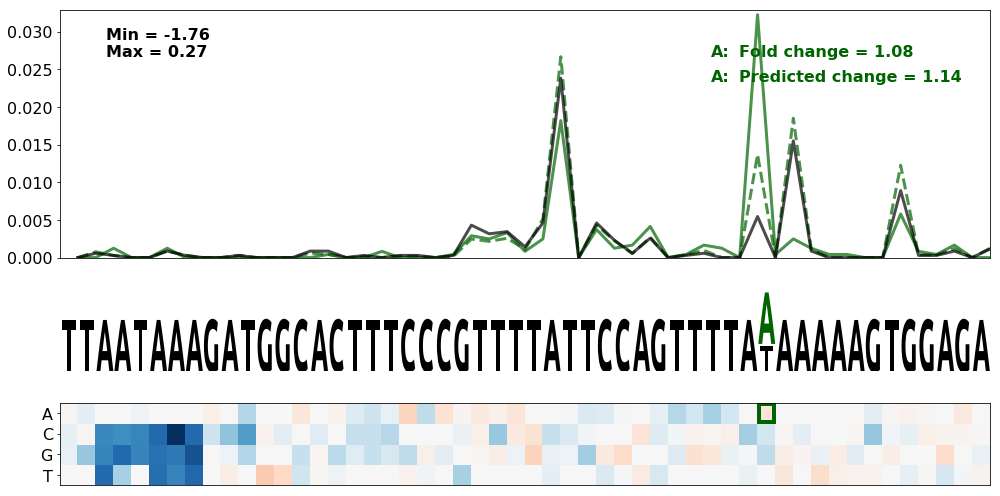

Gene = TPM1.20
WT seq = AACCCTCTGCTGAGTAACCAAGCCTTTAATTTTGTGTTTTTATGAAAGGAATTAAAATACCCACGATAAATATTTACCACAACCTGTGTCAAATAAATGGGAAATTAAACACAGATTGTACAATGTGAGCTTGGGAGTTAATGGCCCAGATTTTACTGTTAGGC
SNV pos = 66
SNV nt = A
ClinVar id = Missing


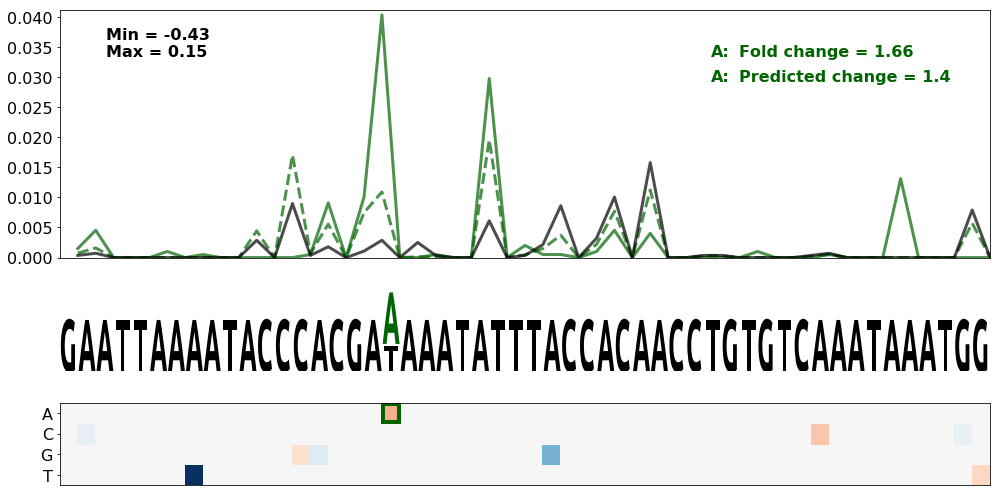

In [9]:
print('Gain of cryptic competing CSE:')

experiment_name = 'gain_of_cryptic_cse'

gene_names = [
    'PTEN.24',
    'DOCK8.2',
    'SMAD4.1',
    'ATP7B.1',
    'BRCA2.1',
    'TPMT.1',
    'BRCA1.1'
]

snv_list = [
    [(72, 'A', 'darkgreen')],
    [(75, 'A', 'darkgreen')],
    [(72, 'C', 'darkgreen')],
    [(74, 'T', 'red')],
    [(63, 'T', 'red')],
    [(75, 'T', 'red')],
    [(80, 'A', 'red')]
]

wt_seq_list = [
    'GAGTTAAGTAATTTCACTGAAATTGATTGCTTTTTGTGTCTTGGAGTCAAAATAAATAACTGAAATCTACTATACTTGGCTCATGCTTAATTAATATACTTAGACCATATTTCGGATGAATTATTCACAGAATCTAAAGGAGTATCCTCGTGTTCTTACCTTCT',
    'ATTTGAGAATTAAATTATATATTTTTAATATGACTGTGACCTTGACTGATAATAAAGATGTAATAAGAATTGCAAGCTAAATGTTTCCCTTTGCAACTCATGCTTTGTGTTTTGTTTTGATGACCTACTCGCTCGTAATGTTTTGTAAGGCACTTCAGAGAGAA',
    'AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT',
    'TTTTTGTCAGATAATCATTTCTACTTCAAAAACATTTCATGCAATATTAGAATAAAGTTCCTGTCATTCCTCTAAAAATCTGCCTGTGAGTGAGATGCGTGGTCAGAGGCCAGTGCCGTCTTGTCTTCACGAGGGCTTCTGTGAGGCACTGGCTTGGCTTCATG',
    'TGTATAATATCATGTTTTCAAATCTAATTATAAATACGTTTAAAGCCAAGAATAAATCTTTTAAAAAATTGACTTGTTTCCTTCCATAACTCTGAGCCATGATTTTTCTGTTCTGTAAAAAGCATTAACAAAATTGTCTATTTTGCTACTCCCTGTAACTTAAG',
    'CCTAAAATCTCAAGATGGAAGATATACCACATGTAAATTATTTTAGAGCAATTAAATTGTTTTCAGGATTTTCCAAAAATGCTTCTTGTTTCATTTTATTATTTAAGTAACAGATTATCTGAGCCTCTGTGCCCTGCACACAGTGGTTTATAAATGCCTTGCCC',
    'ACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCTTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGG'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, fold_change_from_cut_range=[60, 90], seq_start=48, seq_end=100, save_figs=False)

print('Loss of cryptic competing CSE:')

experiment_name = 'loss_of_cryptic_cse'

gene_names = [
    'SMAD4.1',
    'SMAD4.1',
    'PTEN.15',
    'TMEM43.11',
    'PTEN.15',
    'PTEN.15',
    'PTEN.15',
    'TPM1.20'
]

snv_list = [
    [(75, 'T', 'red')],
    [(76, 'T', 'red')],
    [(89, 'C', 'red')],
    [(68, 'C', 'red')],
    [(88, 'G', 'darkgreen')],
    [(88, 'T', 'darkgreen')],
    [(87, 'A', 'darkgreen')],
    [(66, 'A', 'darkgreen')]
]

wt_seq_list = [
    'AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT',
    'AGCTTTAGGTCTAAAGACGATGGTGAATTATGTAGGTTTAAGTTGTTGGAATTAAAACTAAAAGCTTCTTTTGATAAAAGTCGTTATAACATTTTGTGACTCTATTAATAGAAGTGGCTTTTTCTTTGCTTTCCAGGTTTTTGGGCGAGTTTTAAAGAAGTATT',
    'ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA',
    'AGTGAATTTGAGAATTAAATAATACTTGTAAAACACTTAGGACAGTATCAAATAAATGGTGAGTGATAAATGTGACCTGTTTTTGTTGTTACGGACTCTGAGAGAGGGCCCGATTCAGATCAGAGGGTCAGGGAAAGCCCTCTGAAGAAATGGGGTTCAAGCAA',
    'ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA',
    'ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA',
    'ATGTATATACCTTTTTGTGTCAAAAGGACATTTAAAATTCAATTAGGATTAATAAAGATGGCACTTTCCCGTTTTATTCCAGTTTTATAAAAAGTGGAGACAGACTGATGTGTATACGTAGGAATTTTTTCCTTTTGTGTTCTGTCACCAACTGAAGTGGCTAA',
    'AACCCTCTGCTGAGTAACCAAGCCTTTAATTTTGTGTTTTTATGAAAGGAATTAAAATACCCACGATAAATATTTACCACAACCTGTGTCAAATAAATGGGAAATTAAACACAGATTGTACAATGTGAGCTTGGGAGTTAATGGCCCAGATTTTACTGTTAGGC'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, fold_change_from_cut_range=[60, 90], seq_start=48, seq_end=100, save_figs=False)


<h2>Gain/Loss of CFIm25 Binding site (TGTA)</h2>

Gain of Motif (Neural Net model)


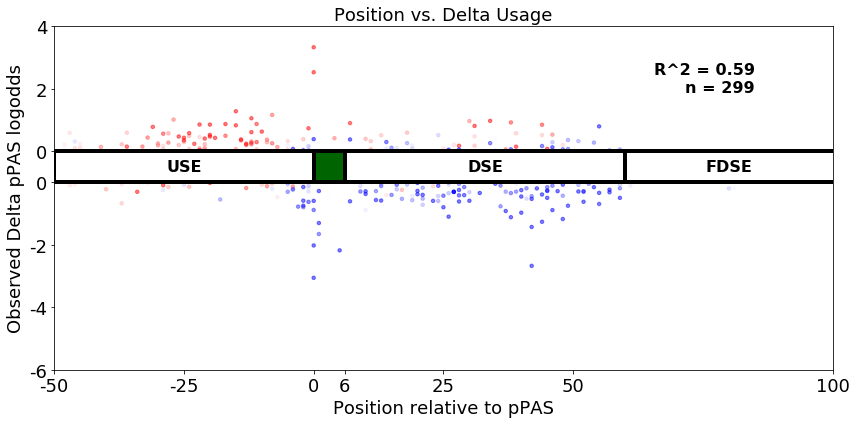

Gain of Motif (Hexamer model)


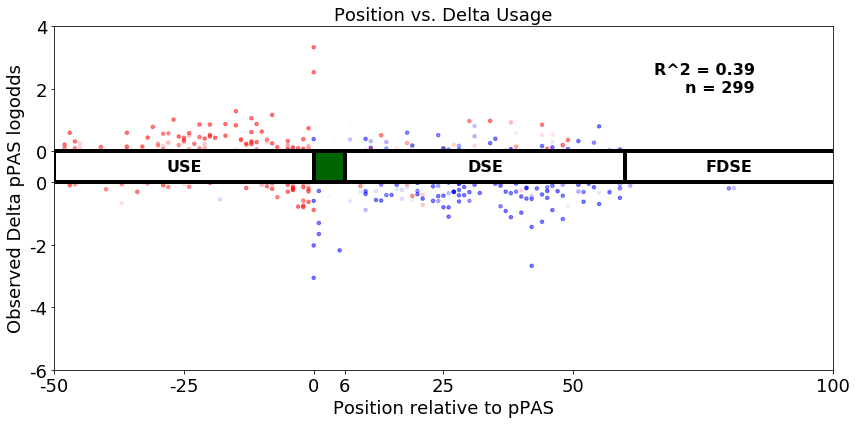


# Gain of ['TGTA'] = 299
# Neural net / Observation agreement = 233
# Neural net / 6-mer model agreement = 243
## Gain of motif in USE = 122
### Gain of motif, Loss of function = 39
### Gain of motif, Gain of function = 83
### Neural net / 6-mer model agreement = 95
## Gain of motif in DSE = 164
### Gain of motif, Loss of function = 109
### Gain of motif, Gain of function = 55
### Neural net / 6-mer model agreement = 138
Loss of Motif (Neural Net model)


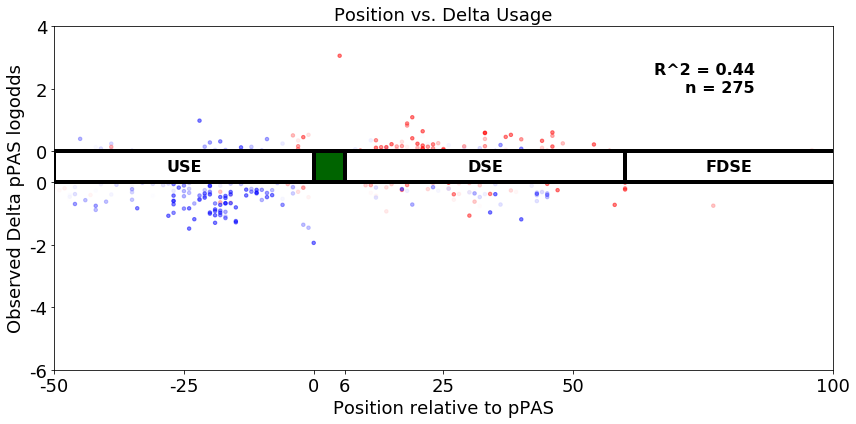

Loss of Motif (Hexamer model)


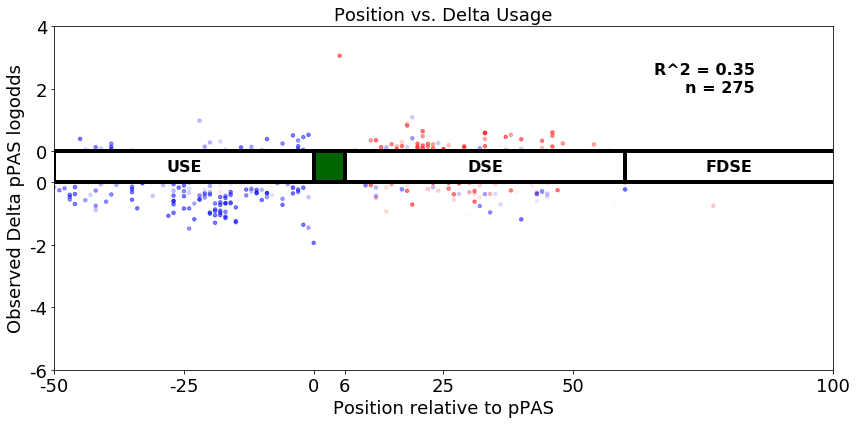


# Loss of ['TGTA'] = 275
# Neural net / Observation agreement = 199
# Neural net / 6-mer model agreement = 220
## Loss of motif in USE = 151
### Loss of motif, Loss of function = 123
### Loss of motif, Gain of function = 28
### Neural net / 6-mer model agreement = 132
## Loss of motif in DSE = 122
### Loss of motif, Loss of function = 61
### Loss of motif, Gain of function = 61
### Neural net / 6-mer model agreement = 86


In [10]:
#Gain/Loss of TGTA
motifs = ['TGTA']
gain_of_motif_df, loss_of_motif_df = plot_gain_loss_of_motifs(var_df, motifs, name_prefix='tgta', plot_logos=False, save_figs=False)


Gain of overlapping TGTA/CSE:
Gene = INS.1
WT seq = CAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTG
SNV pos = 49
SNV nt = T
ClinVar id = Missing


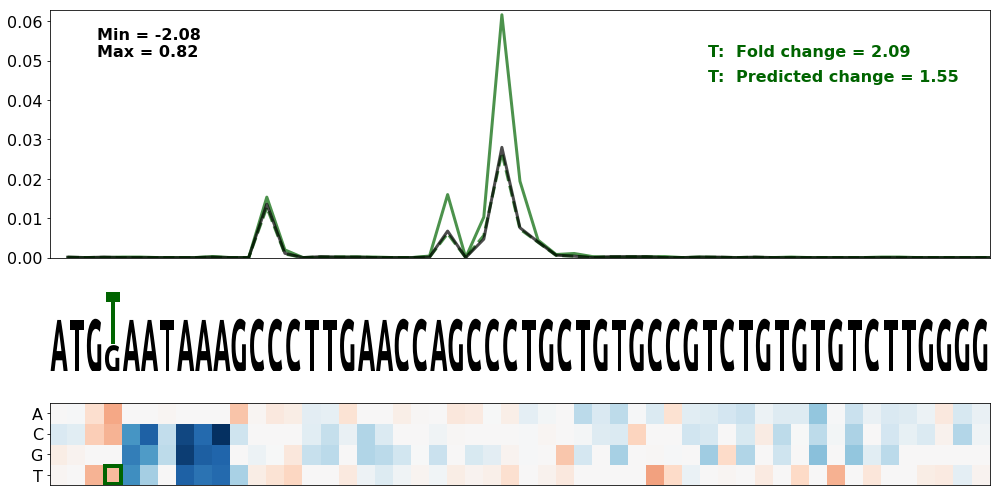

Gene = SNRNP200.3
WT seq = TATAGCATTTTCAGGCATGTTCCTGGTAGTTCTTTTGAGTCTGACATTCTAATAAAATAATTTGTAGAAACCATTTGTCTTTGTAGTGATTCCAAATTAAAAGTTTTCTTTCTCCAACCTGAGGGCACGGCCAAAAAGATCTGGTTATTTTTTAGCCAGGAACG
SNV pos = 48
SNV nt = G
ClinVar id = NM_014014.4(SNRNP200):c.*257C>G


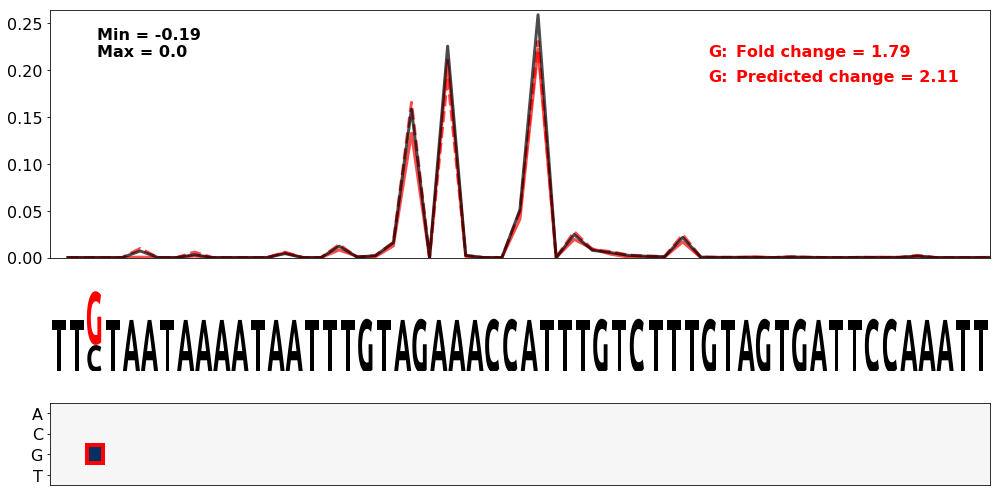

In [11]:
print('Gain of overlapping TGTA/CSE:')

experiment_name = 'gain_of_overlapping_tgta'

gene_names = [
    'INS.1',
    'SNRNP200.3'
]

snv_list = [
    [(49, 'T', 'darkgreen')],
    [(48, 'G', 'red')],
]

wt_seq_list = [
    'CAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTG',
    'TATAGCATTTTCAGGCATGTTCCTGGTAGTTCTTTTGAGTCTGACATTCTAATAAAATAATTTGTAGAAACCATTTGTCTTTGTAGTGATTCCAAATTAAAAGTTTTCTTTCTCCAACCTGAGGGCACGGCCAAAAAGATCTGGTTATTTTTTAGCCAGGAACG'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, seq_start=46, seq_end=98, save_figs=False)


In [12]:
#Load position nmer weights and build decoder dicts

simple_pos_weights = np.load('apa_4mer_pos_weights/simple_position_nmer_weights.npy')

mer4_dict, mer4_list = {}, []
bases = list('ACGT')

#Build dictionary of 4-mer -> index
i4 = 0
for b1 in bases :
    for b2 in bases :
        for b3 in bases :
            for b4 in bases :
                mer4_dict[b1 + b2 + b3 + b4] = i4
                mer4_list.append(b1 + b2 + b3 + b4)
                i4 += 1


Wildtype Isoform Abundance vs. Variant Effect


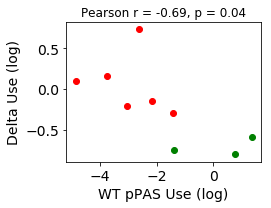

Wildtype Isoform Abundance vs. Variant Effect (4mer scores subtracted from effect size)


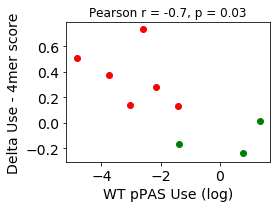

In [13]:
#Compare delta log fold change against wildtype isoform abundance
save_figs = False

tgta_boundary_df = gain_of_motif_df.query("snv_pos >= 47 and snv_pos <= 49")

slice_index = tgta_boundary_df.index.str.slice(47, 50).str.contains('TGT')
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('AATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('ATTAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('TATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('CATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('GATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('AGTAAA'))
tgta_boundary_df = tgta_boundary_df[slice_index]

has_up_tgta = tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('TGTA') | tgta_boundary_df.wt_seq.str.slice(57, 110).str.contains('TGTA')
not_up_tgta = ~(tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('TGTA') | tgta_boundary_df.wt_seq.str.slice(57, 110).str.contains('TGTA'))

r_val, p_val = pearsonr(tgta_boundary_df['pooled_proximal_logodds_ref'], tgta_boundary_df['delta_logodds_true'])

print("Wildtype Isoform Abundance vs. Variant Effect")

f = plt.figure(figsize=(4, 3))

plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[has_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[has_up_tgta], c='green')
plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[not_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[not_up_tgta], c='red')

plt.xlabel('WT pPAS Use (log)', fontsize=14)
plt.ylabel('Delta Use (log)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Pearson r = ' + str(round(r_val, 2)) + ', p = ' + str(round(p_val, 2)))

plt.tight_layout()

if save_figs :
    fig_name = 'gain_of_overlapping_tgta_scatter'
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')

plt.show()

#Subtract 4mer delta score from measured variant delta fold change
linear_boundary_delta = np.zeros(len(tgta_boundary_df))

i = 0
for index, row in tgta_boundary_df.iterrows() :
    
    var_score = 0
    ref_score = 0
    for offset in range(-3, 3 + 1) :
        var_mer = index[46 + offset: 50 + offset]
        ref_mer = row['wt_seq'][46 + offset: 50 + offset]
        
        rel_pos = 46 + offset
        
        var_score += simple_pos_weights[rel_pos * 256 + mer4_dict[var_mer]]
        ref_score += simple_pos_weights[rel_pos * 256 + mer4_dict[ref_mer]]
    
    linear_boundary_delta[i] = var_score - ref_score
    
    i += 1

r_val, p_val = pearsonr(tgta_boundary_df['pooled_proximal_logodds_ref'], tgta_boundary_df['delta_logodds_true'] - linear_boundary_delta)

print("Wildtype Isoform Abundance vs. Variant Effect (4mer scores subtracted from effect size)")

f = plt.figure(figsize=(4, 3))

plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[has_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[has_up_tgta] - linear_boundary_delta[has_up_tgta], c='green')
plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[not_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[not_up_tgta] - linear_boundary_delta[not_up_tgta], c='red')

plt.xlabel('WT pPAS Use (log)', fontsize=14)
plt.ylabel('Delta Use - 4mer score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Pearson r = ' + str(round(r_val, 2)) + ', p = ' + str(round(p_val, 2)))

plt.tight_layout()

if save_figs :
    fig_name = 'gain_of_overlapping_tgta_scatter_multi_4mer_correction'
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')

plt.show()





<h2>Gain/Loss of CstF Binding site (TGTCT/TGTGT)</h2>

Gain of Motif (Neural Net model)


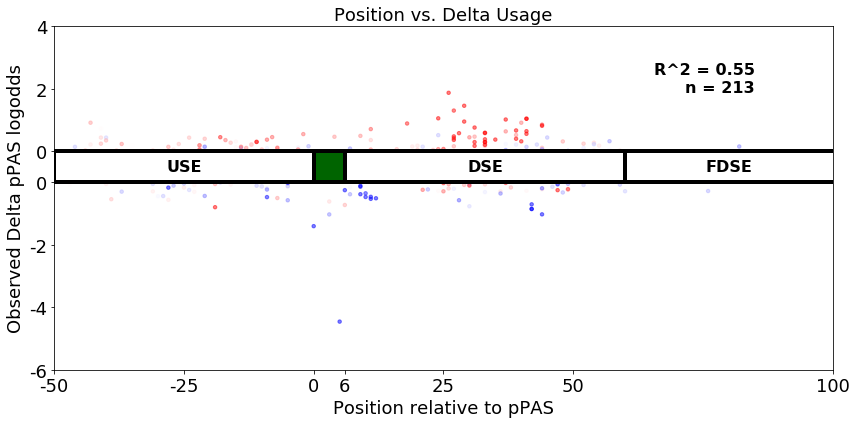

Gain of Motif (Hexamer model)


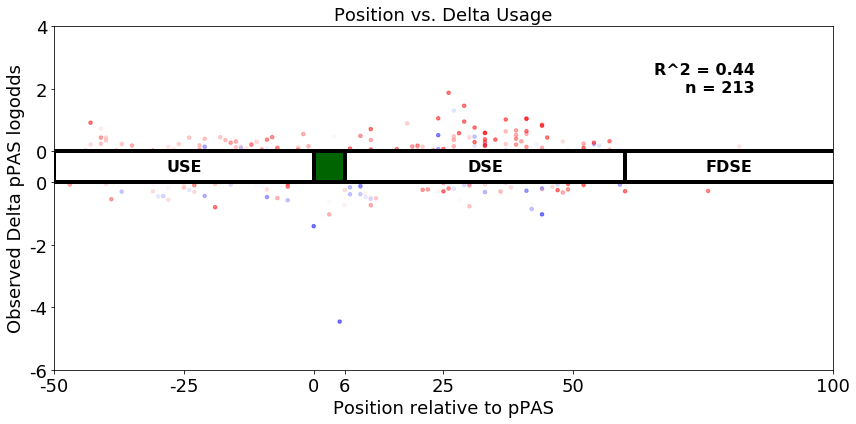


# Gain of ['TGTCT', 'TGTGT'] = 213
# Neural net / Observation agreement = 151
# Neural net / 6-mer model agreement = 150
## Gain of motif in USE = 83
### Gain of motif, Loss of function = 34
### Gain of motif, Gain of function = 49
### Neural net / 6-mer model agreement = 60
## Gain of motif in DSE = 125
### Gain of motif, Loss of function = 50
### Gain of motif, Gain of function = 75
### Neural net / 6-mer model agreement = 88
Loss of Motif (Neural Net model)


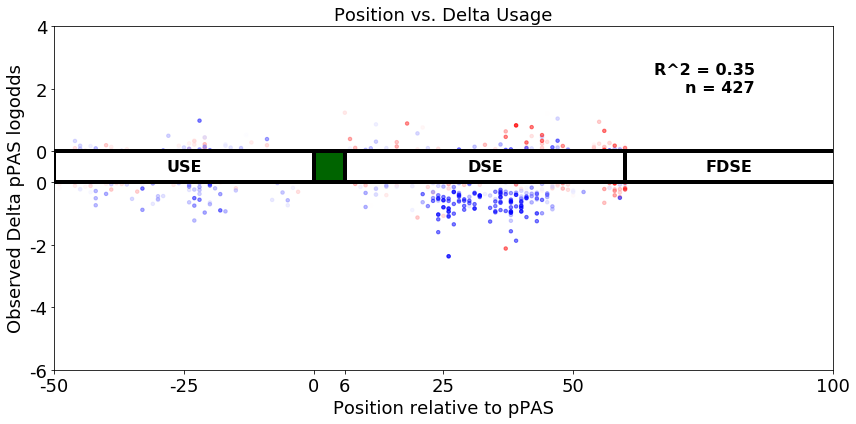

Loss of Motif (Hexamer model)


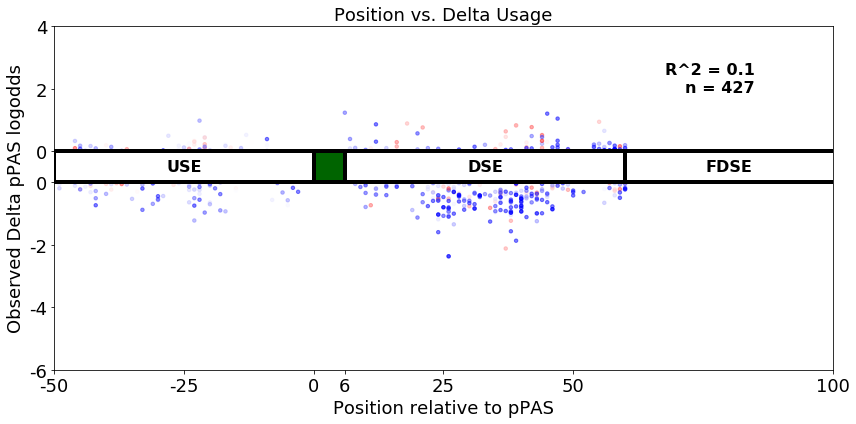


# Loss of ['TGTCT', 'TGTGT'] = 427
# Neural net / Observation agreement = 303
# Neural net / 6-mer model agreement = 332
## Loss of motif in USE = 115
### Loss of motif, Loss of function = 70
### Loss of motif, Gain of function = 45
### Neural net / 6-mer model agreement = 97
## Loss of motif in DSE = 312
### Loss of motif, Loss of function = 229
### Loss of motif, Gain of function = 83
### Neural net / 6-mer model agreement = 235


In [14]:
#Gain/Loss of CSTF site (CSE Hexamer)
motifs = ['TGTCT', 'TGTGT']
_, _ = plot_gain_loss_of_motifs(var_df, motifs, name_prefix='tgtct', plot_logos=False, save_figs=False)


Gain of TGT[C/G]T:
Gene = PRKAG2.1
WT seq = CTATCGATTAAAATTCTACATGCAGTTTTCCACTTAGCTATTTCTCCCCAAATAAAGAAGTACATGAATTTCATCTCTTTTCCGGTATCAGGAAAAAAAGTCAGGGTTTAATTCATAAACTCTCTCTCTCCACTATTAAGTATGAATATATGTATTTATTATTT
SNV pos = 74
SNV nt = G
ClinVar id = Missing


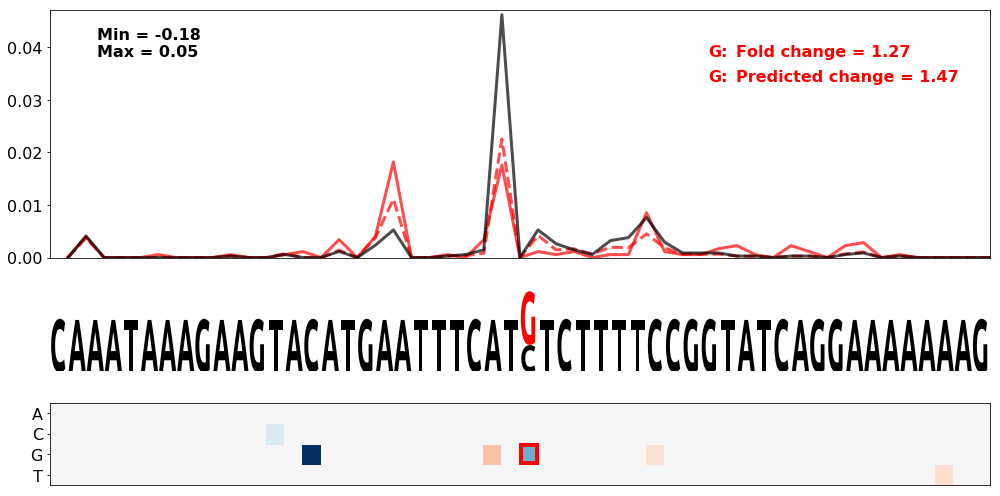

Gene = RYR2.5
WT seq = AGAAACAAGTTGATCAACGTGAGAGAAATTTCATGATAATTATTCATAGTAATAAAGTGTCGTGGGCTTAATTGTATATCTGGAGCCAGTGTCATCCACCAACAATGTGATACAATATGAACTTGACAGTAGTTTTGGGTTTTGCTCATTCTTTCAGCCACCTG
SNV pos = 75
SNV nt = G
ClinVar id = Missing


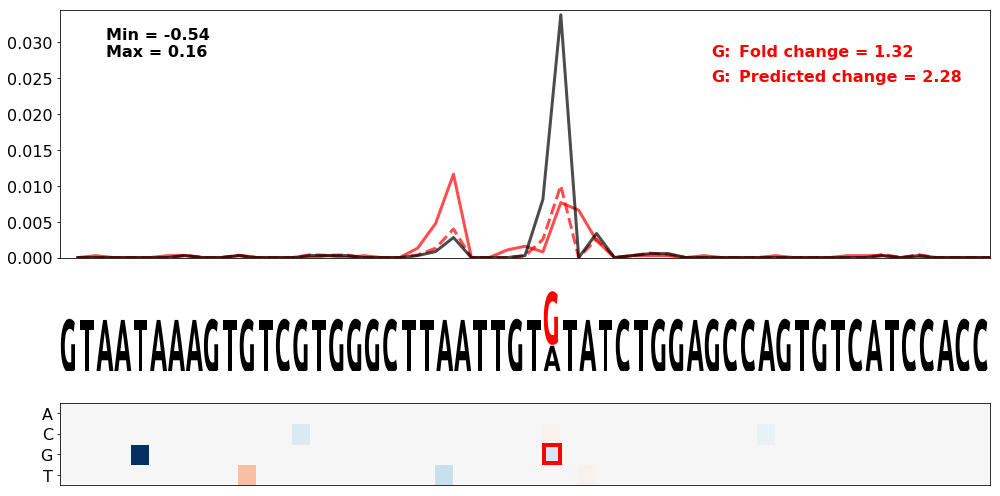

Gene = TP53.3
WT seq = CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG
SNV pos = 73
SNV nt = C
ClinVar id = Missing


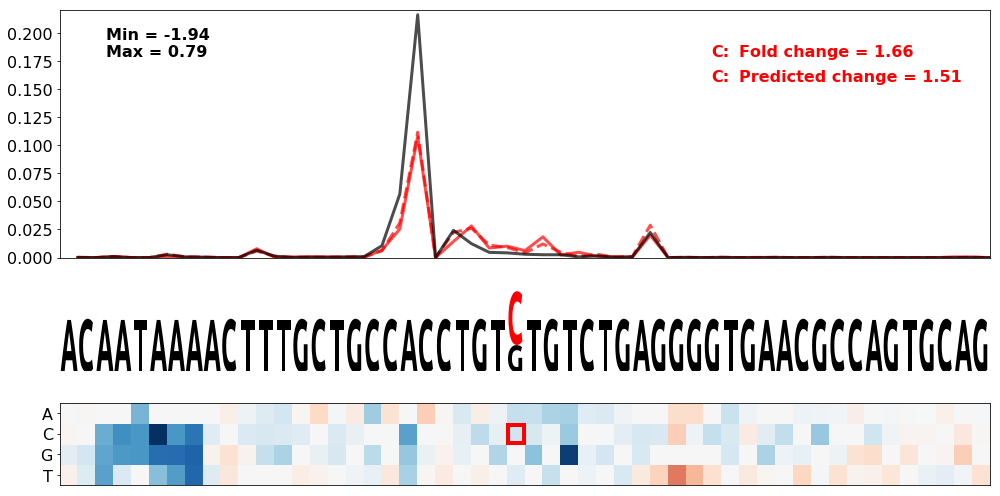

Loss of TGT[C/G]T:
Gene = PTEN.13
WT seq = GCTATCAACAAAGAATGGGCTTGAAACATTATAAAAATTGACAATGATTTATTAAATATGTTTTCTCAATTGTAACGACTTCTCCATCTCCTGTGTAATCAAGGCCAGTGCTAAAATTCAGATGCTGTTAGTACCTACATCAGTCAACAACTTACACTTATTTT
SNV pos = 92
SNV nt = T
ClinVar id = Missing


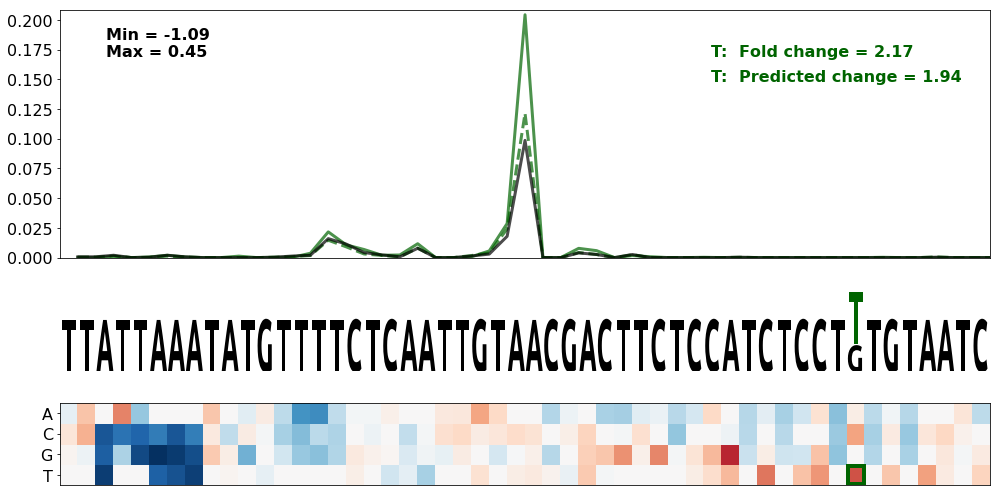

Gene = PTEN.8
WT seq = AGATGTCCATTTGTTATTGTGTTTGTTAACAACCCTTTATCTCTTAGTGTTATAAACTCCACTTAAAACTGATTAAAGTCTCATTCTTGTCATTGTGTGGGTGTTTTATTAAATGAGAGTTTATAATTCAAATTGCTTAAGTCCATTGAAGTTTTAATTAATGG
SNV pos = 95
SNV nt = G
ClinVar id = Missing


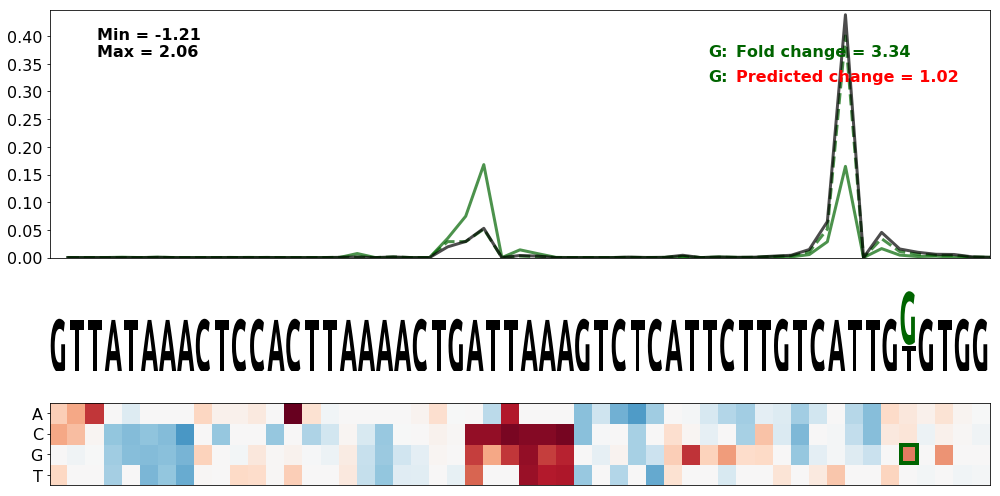

Gene = INS.1
WT seq = CAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTG
SNV pos = 89
SNV nt = T
ClinVar id = Missing


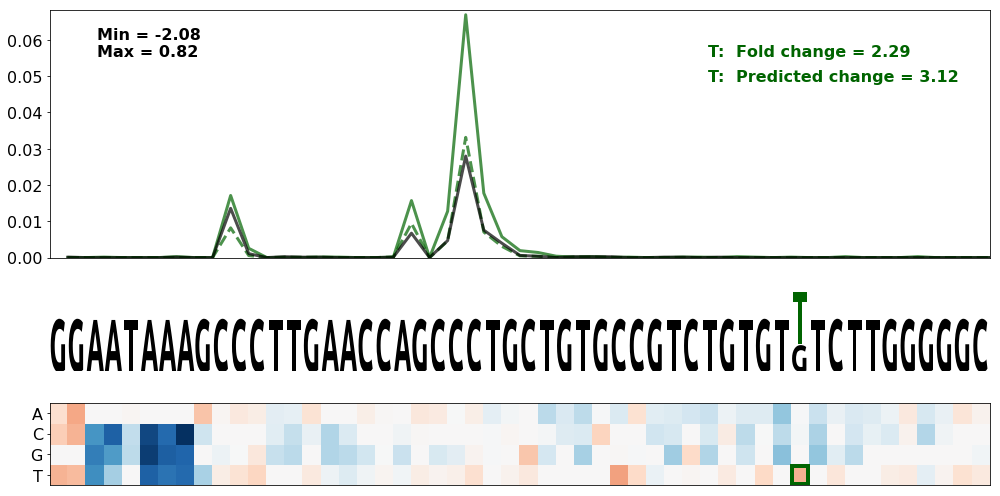

In [15]:
print('Gain of TGT[C/G]T:')

experiment_name = 'gain_of_tgtct'

gene_names = [
    'PRKAG2.1',
    'RYR2.5',
    'TP53.3'
]

snv_list = [
    [(74, 'G', 'red')],
    [(75, 'G', 'red')],
    [(73, 'C', 'red')]
]

wt_seq_list = [
    'CTATCGATTAAAATTCTACATGCAGTTTTCCACTTAGCTATTTCTCCCCAAATAAAGAAGTACATGAATTTCATCTCTTTTCCGGTATCAGGAAAAAAAGTCAGGGTTTAATTCATAAACTCTCTCTCTCCACTATTAAGTATGAATATATGTATTTATTATTT',
    'AGAAACAAGTTGATCAACGTGAGAGAAATTTCATGATAATTATTCATAGTAATAAAGTGTCGTGGGCTTAATTGTATATCTGGAGCCAGTGTCATCCACCAACAATGTGATACAATATGAACTTGACAGTAGTTTTGGGTTTTGCTCATTCTTTCAGCCACCTG',
    'CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, fold_change_from_cut_range=[60, 90], seq_start=48, seq_end=100, save_figs=False)

print('Loss of TGT[C/G]T:')

experiment_name = 'loss_of_tgtct'

gene_names = [
    'PTEN.13',
    'PTEN.8',
    'INS.1'
]

snv_list = [
    [(92, 'T', 'darkgreen')],
    [(95, 'G', 'darkgreen')],
    [(89, 'T', 'darkgreen')]
]

wt_seq_list = [
    'GCTATCAACAAAGAATGGGCTTGAAACATTATAAAAATTGACAATGATTTATTAAATATGTTTTCTCAATTGTAACGACTTCTCCATCTCCTGTGTAATCAAGGCCAGTGCTAAAATTCAGATGCTGTTAGTACCTACATCAGTCAACAACTTACACTTATTTT',
    'AGATGTCCATTTGTTATTGTGTTTGTTAACAACCCTTTATCTCTTAGTGTTATAAACTCCACTTAAAACTGATTAAAGTCTCATTCTTGTCATTGTGTGGGTGTTTTATTAAATGAGAGTTTATAATTCAAATTGCTTAAGTCCATTGAAGTTTTAATTAATGG',
    'CAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTG'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, seq_start=48, seq_end=100, save_figs=False)


<h2>DSE Secondary Structure Variants</h2>

In [16]:
#Calculate mean cut position in variant and wildtype DSEs
var_df['avg_pos_true_ref'] = var_df['cut_prob_true_ref'].apply(lambda p: np.sum(np.arange(len(p[57:110])) * (p[57:110] / np.sum(p[57:110]))))
var_df['avg_pos_true_var'] = var_df['cut_prob_true_var'].apply(lambda p: np.sum(np.arange(len(p[57:110])) * (p[57:110] / np.sum(p[57:110]))))

pas_dict = {'AATAAA' : True, 'ATTAAA' : True, 'TATAAA' : True, 'GATAAA' : True, 'CATAAA' : True, 'AGTAAA' : True, 'ACTAAA' : True, 'AAGAAA' : True, 'AGGAAA' : True, 'AACAAA' : True, 'AATAAT' : True}

#Filter out variants creating de novo CSE hexamers in the DSE
#Reason: The shift in cut position is not due to 2ary structure but new CSEs
keep_index = []
i = 0
for _, row in var_df.iterrows() :
    snv_pos = row['snv_pos']

    var_region = row['master_seq'][57:105]
    ref_region = row['wt_seq'][57:105]

    pas_found = False
    for pas in pas_dict :
        if pas in var_region or pas in ref_region :
            pas_found = True
            break

    if not pas_found :
        keep_index.append(i)

    i += 1

var_df_no_pas = var_df.iloc[keep_index].copy()
var_df_no_pas['delta_pos_true'] = var_df_no_pas['avg_pos_true_var'] - var_df_no_pas['avg_pos_true_ref']


In [17]:
#Store/load folded wildtype/variant sequences
#var_df_no_pas[['master_seq', 'wt_seq']].to_csv('folding/array_cut_var_seqs.csv', sep=',')
var_df_no_pas_fold = pd.read_csv('folding/array_cut_var_seqs_folded.csv', sep=',')
var_df_no_pas = var_df_no_pas.join(var_df_no_pas_fold.set_index('master_seq'), on='master_seq', rsuffix='folded')

In [18]:
#Filter variants on large delta MFEs calculated from ViennaRNA fold
keep_index = []

i = 0
for _, row in var_df_no_pas.iterrows() :
    mfe_var = row['mfe_var']
    mfe_ref = row['mfe_wt']
    delta_mfe = row['delta_mfe']
    
    if delta_mfe < -2 and mfe_var < -4.0 :
        keep_index.append(i)
    
    i += 1

var_df_foldchange = var_df_no_pas.iloc[keep_index]


Folding alteration variants:
Gene = MLH1.2
SNV pos = 69
SNV nt = A
ClinVar id = Missing


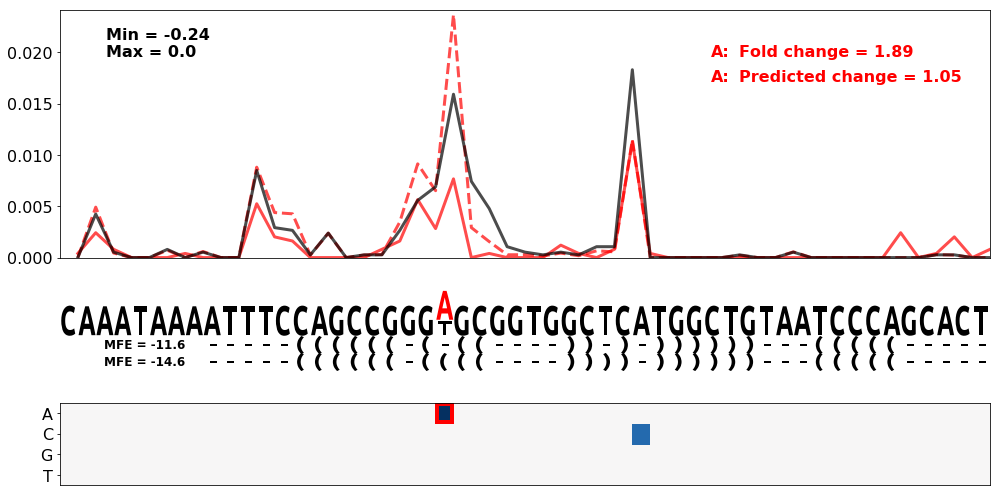

Gene = ARSA.3
SNV pos = 83
SNV nt = G
ClinVar id = Missing


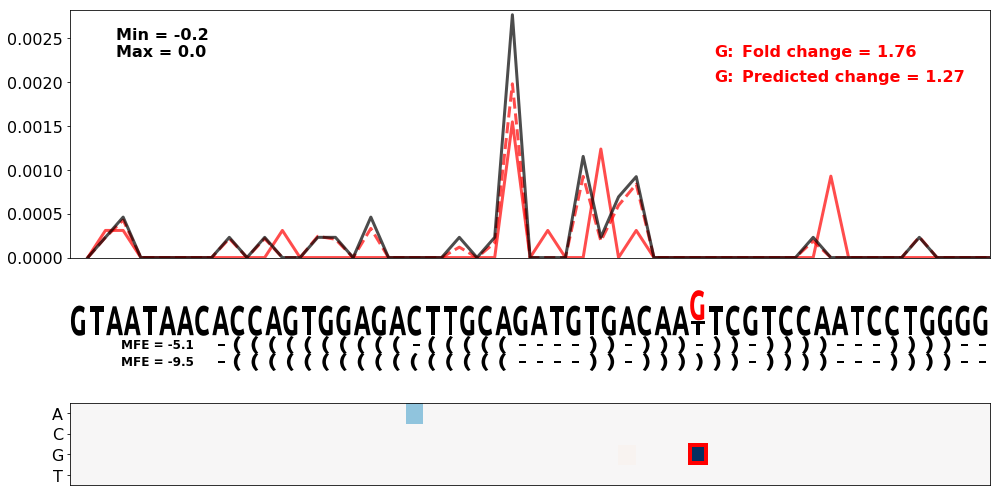

Gene = TP53.3
WT seq = CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG
SNV pos = 76
SNV nt = G
ClinVar id = Missing


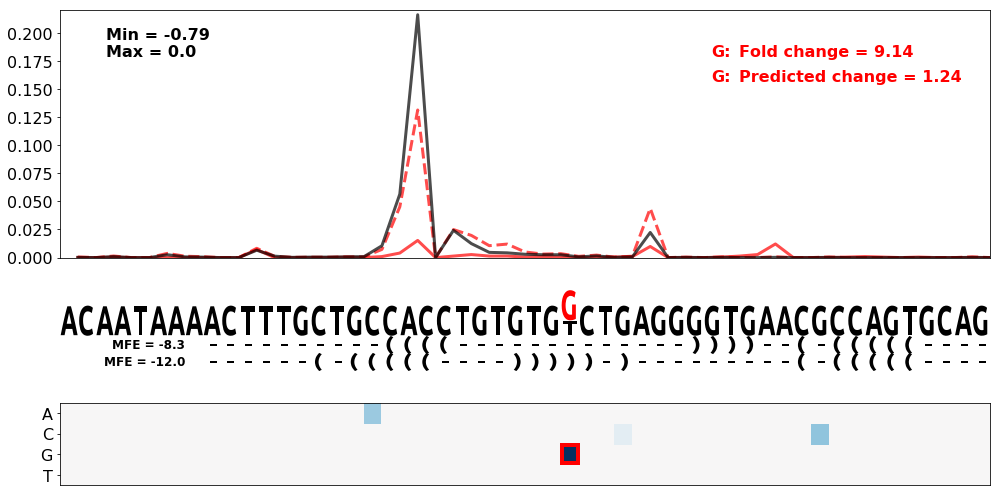

Gene = PTEN.16
SNV pos = 107
SNV nt = G
ClinVar id = Missing


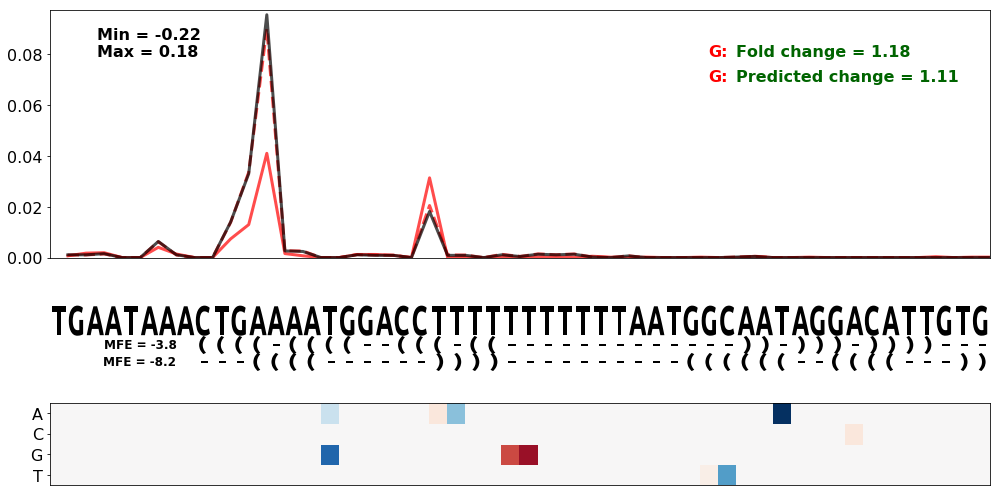

Gene = NF2.3
SNV pos = 97
SNV nt = G
ClinVar id = Missing


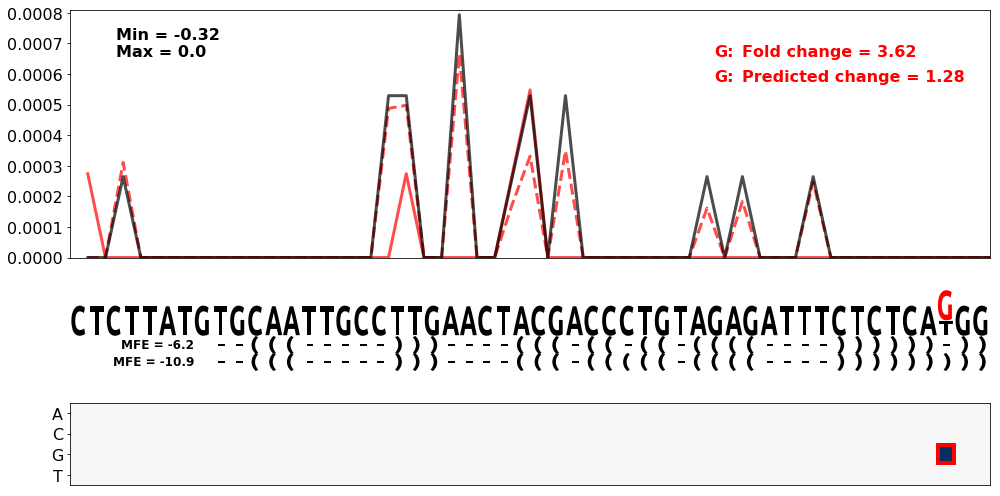

Gene = LDLR.4
SNV pos = 66
SNV nt = G
ClinVar id = Missing


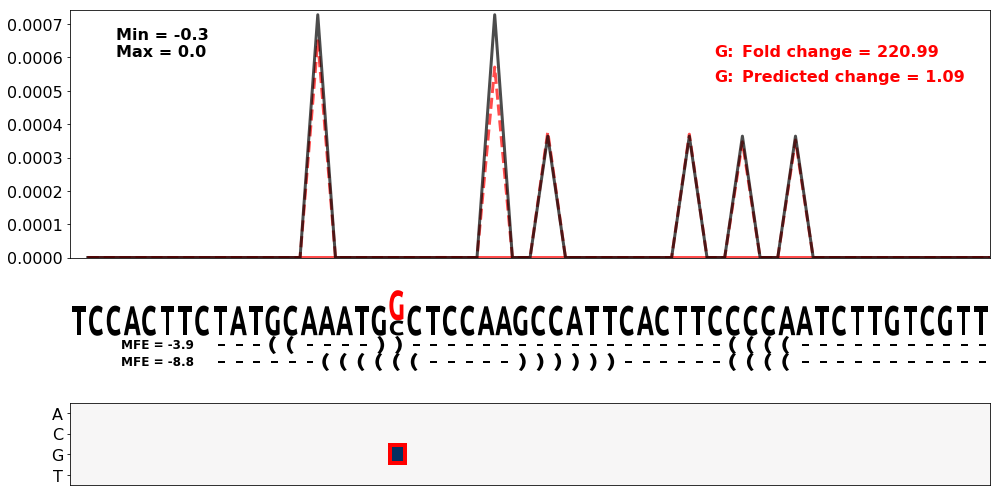

Gene = PEX5.3
SNV pos = 74
SNV nt = C
ClinVar id = NM_001131025.1(PEX5):c.*1259G>C


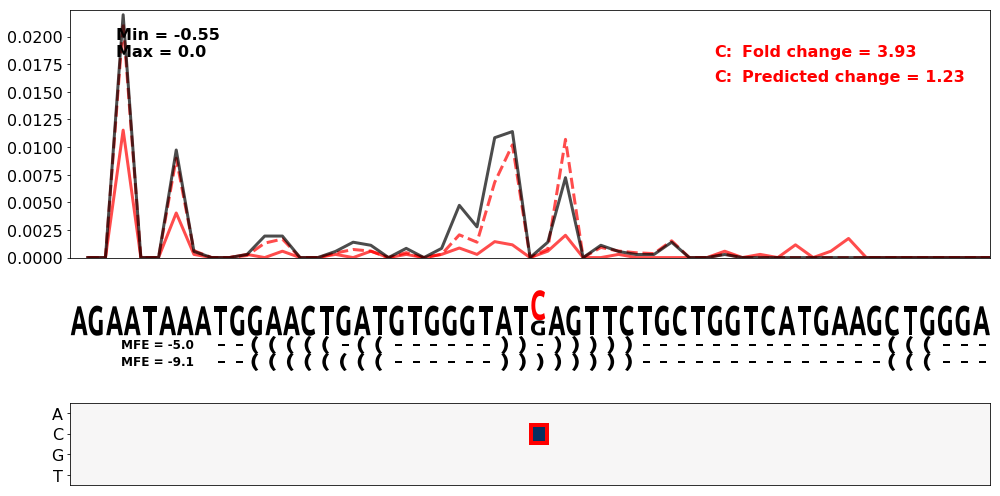

Gene = BRCA1.1
SNV pos = 72
SNV nt = A
ClinVar id = Missing


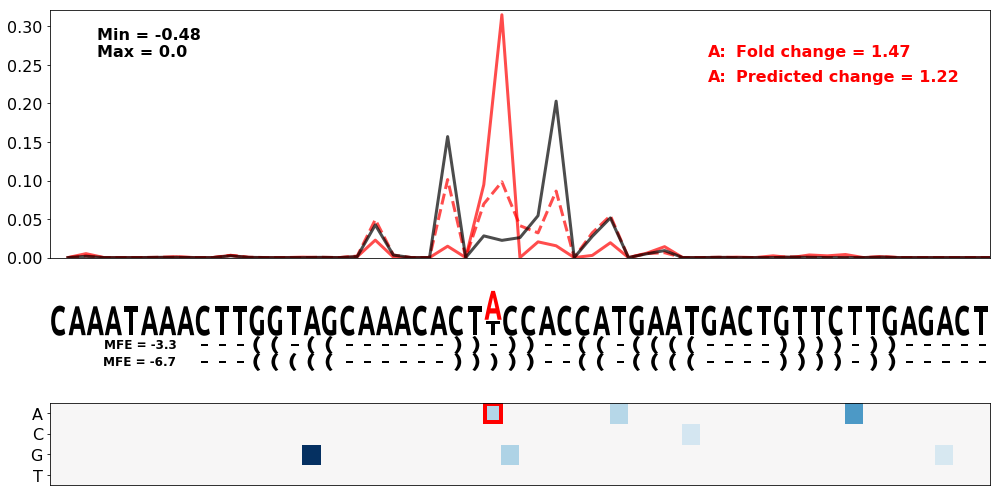

Gene = TP53.3
WT seq = CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG
SNV pos = 65
SNV nt = A
ClinVar id = Missing


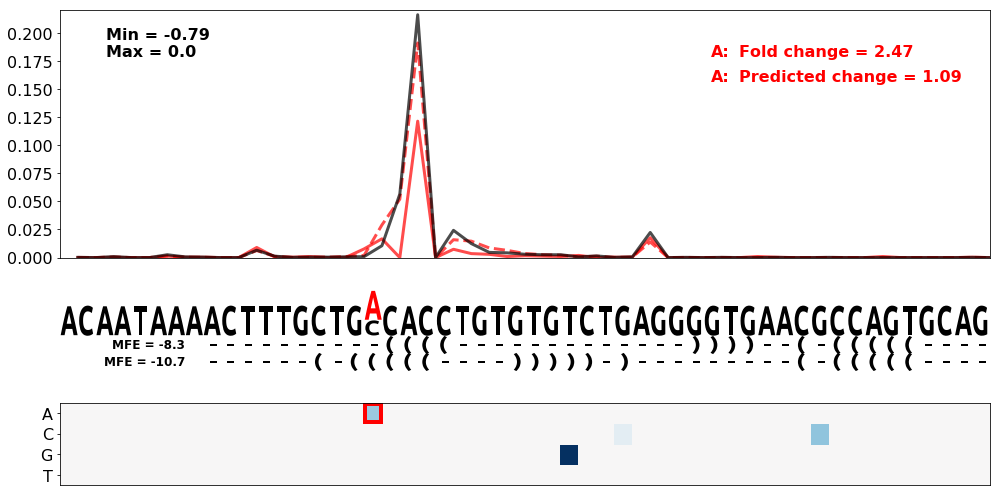

Gene = FRA10AC1.1
SNV pos = 68
SNV nt = G
ClinVar id = NM_006204.3(PDE6C):c.*209T>C


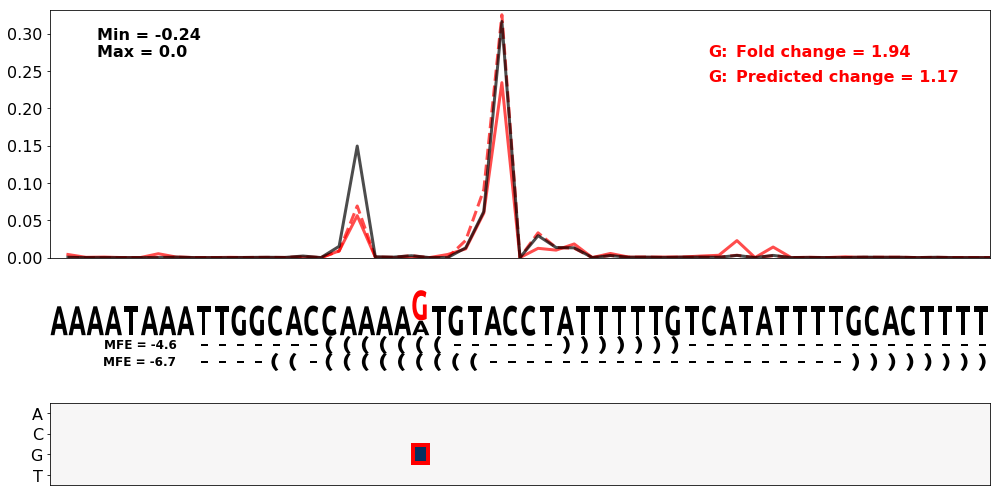

Gene = TGFBR2.3
SNV pos = 68
SNV nt = G
ClinVar id = Missing


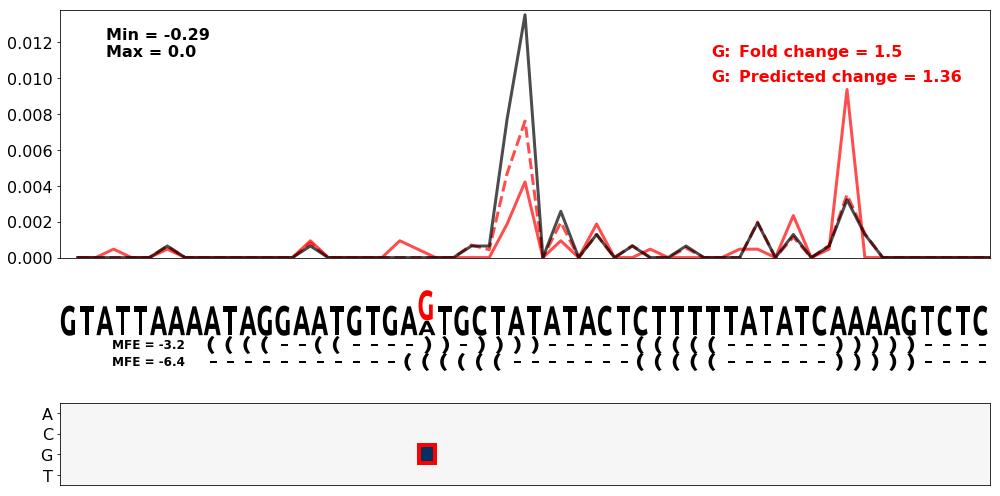

In [19]:
print('Folding alteration variants:')

experiment_name = 'folding'

gene_names = [
    'MLH1.2',
    'ARSA.3',
    'TP53.3',
    'PTEN.16',
    'NF2.3',
    'LDLR.4',
    'PEX5.3',
    'BRCA1.1',
    'TP53.3',
    'FRA10AC1.1',
    'TGFBR2.3'
]

snv_list = [
    [(69, 'A', 'red')],
    [(83, 'G', 'red')],
    [(76, 'G', 'red')],
    [(107, 'G', 'red')],
    [(97, 'G', 'red')],
    [(66, 'G', 'red')],
    [(74, 'C', 'red')],
    [(72, 'A', 'red')],
    [(65, 'A', 'red')],
    [(68, 'G', 'red')],
    [(68, 'G', 'red')]
]

wt_seq_list = [
    None,
    None,
    'CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG',
    None,
    None,
    None,
    None,
    None,
    'CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG',
    None,
    None
]

seq_start = 48
seq_end = 100

save_figs = False

df_to_use = var_df_foldchange.set_index('master_seq')#df_var_no_pas.set_index('master_seq')

for gene_name, snvs, specific_seq in zip(gene_names, snv_list, wt_seq_list) :
    df_sel = df_to_use
    if specific_seq is not None :
        df_sel = df_to_use.query("wt_seq == '" + specific_seq + "'")

    print('Gene = ' + gene_name)
    if specific_seq is not None :
        print('WT seq = ' + specific_seq)
    print('SNV pos = ' + str(snvs[0][0]))
    print('SNV nt = ' + str(snvs[0][1]))
    print('ClinVar id = ' + str(df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['clinvar_id'].values[0]))
    
    struct_var = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['struct_var'].values[0]
    struct_ref = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['struct_wt'].values[0]
    struct_var = ('X' * 56) + struct_var + ('X' * 100)
    struct_ref = ('X' * 56) + struct_ref + ('X' * 100)
    
    mfe_var = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['mfe_var'].values[0]
    mfe_ref = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['mfe_wt'].values[0]
    delta_mfe = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['delta_mfe'].values[0]
    
    fig_name = None
    if save_figs :
        fig_name = experiment_name + '_' + gene_name + '_' + str(snvs[0][0]) + '_' + str(snvs[0][1]) + '_Both'
    mut_map_with_cuts_and_fold(
            df_sel,
            gene_name,
            mfe_ref,
            mfe_var,
            struct_ref,
            struct_var,
            snvs,
            mode='true',
            column_suffix='',
            figsize=(14, 7),
            height_ratios=[6, 2, 2],
            bg_alpha=0.999,
            plot_simple_mutmap=True,
            annotate_folds=True,
            plot_true_cuts=True,
            plot_pred_cuts=True,
            scale_pred_cuts=True,
            fold_change_from_cut_range=[60, 100],
            ref_var_scales=[0.5, 1.0],
            border_eta = 0.06,
            seq_trim_start=seq_start, seq_trim_end=seq_end,
            plot_start=0, plot_end=seq_end-seq_start,
            plot_as_bars=False,
            pas_downscaling=0.5,
            fig_name=fig_name,
            fig_dpi=150
    )